<h3>Importing the required libraries</h3>
<p>Loading the libraries that are going to be used during the analysis.</p>

In [1]:
#Importing the required libraries.
#rp.summary_cont(df['libido'])
from pylab import plot, show, savefig, xlim, figure, ylim, legend, boxplot, setp, axes
import statsmodels.api as sm
from statsmodels.formula.api import ols
import math
import seaborn as sns
import pandas as pd
import dask.dataframe as dd
import dask.array as da
from dask.distributed import Client as client
import numpy as np
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.impute import KNNImputer
from sklearn import linear_model
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import sys
import scipy.stats
from scipy.stats import shapiro
from scipy.stats import levene
import csv
import inspect
%run -i '/home/juan-david/Documents/data_science/course_openclassrooms/projet_3/livrables/p3_exploration_fonctions_aide.py'

<h3>1. Loading the dataframe resulting from the cleaning phase.</h3>
<p>The open food facts file is imported as a dask object, then is transformed as a pandas object given that the original dimension was reduced in the cleaning phase.</p>

In [2]:
data = dd.read_csv('/home/juan-david/Documents/data_science/course_openclassrooms/projet_3/donnees/donnees_analyse_exploratoire.csv/*.part',dtype={'code' : 'object','ingredients_text':'object'})
data = data.compute()
data = data.drop(['Unnamed: 0'], axis=1)
data = data.reset_index(drop=True)
#print(data.head(50))

In [3]:
#Check dataframe shape.
print(data.shape)
data.head(5)

(3138, 91)


code                              product_name  \
0  3401562046203                                 5 Légumes   
1  3401562075586                          Picot - riz miel   
2  3263859391218  Carré à la crème (29,5 % MG) 12 Portions   
3  3401596716356                                  Relais 2   
4  0076677100145                            Chocolate Chip   

                                          categories  \
0                      Céréales pour bébé,dès 4 mois   
1                                 Aliments pour bébé   
2  Frais,Produits à tartiner,Produits à tartiner ...   
3  Aliments pour bébé,Laits pour bébé,Laits 2ème âge   
4  Sugary snacks,Biscuits and cakes,Biscuits,Cookies   

                                     categories_tags  \
0  en:baby-foods,en:cereals-for-babies,en:from-4-...   
1                                      en:baby-foods   
2  en:fresh-foods,en:spreads,en:salted-spreads,en...   
3      en:baby-foods,en:baby-milks,fr:laits-2eme-age   
4  en:sugary-snacks,en:biscuits-and-cakes,en:bisc...   

                                       categories_en  \
0        Baby foods,Cereals for babies,From 4 months   
1                                         Baby foods   
2  Fresh foods,Spreads,Salted spreads,Dairies,Che...   
3            Baby foods,Baby milks,fr:Laits 2ème âge   
4  Sugary snacks,Biscuits and cakes,Biscuits,Cookies   

                  countries              countries_tags          countries_en  \
0                    France                   en:france                France   
1                    France                   en:france                France   
2                    France                   en:france                France   
3                    France                   en:france                France   
4  United States, en:france  en:france,en:united-states  France,United States   

                                    ingredients_text  additives_n  ...  \
0  Crème de riz (40,5%), maltodextrines, farine d...          3.0  ...   
1  Crème de riz (64%), maltodextrines, fructose, ...          3.0  ...   
2  Fromage blanc (dont _lait_ 38 %), _crème_ (27 ...          4.0  ...   
3  Lactose, maltodextrines, crème, lait écrémé, h...         13.0  ...   
4  ENRICHED FLOUR (_WHEAT_ FLOUR), NIACIN, REDUCE...          3.0  ...   

  fruits-vegetables-nuts_100g fruits-vegetables-nuts-estimate_100g  \
0                         NaN                                  NaN   
1                         NaN                                  NaN   
2                         NaN                                  NaN   
3                         NaN                                  NaN   
4                         NaN                                  NaN   

   collagen-meat-protein-ratio_100g  cocoa_100g  carbon-footprint_100g  \
0                               NaN         NaN                    NaN   
1                               NaN         NaN                    NaN   
2                               NaN         NaN                    NaN   
3                               NaN         NaN                    NaN   
4                               NaN         NaN                    NaN   

   nutrition_score_fr_100g  nutrition_score_uk_100g  in_france  \
0                      0.0                      0.0       True   
1                      1.0                      1.0       True   
2                     13.0                     18.0       True   
3                     26.0                     26.0       True   
4                     19.0                     19.0       True   

   sum_healthy_composals  proportion_health_composals  
0                      4                     0.181818  
1                      1                     0.058824  
2                      1                     0.125000  
3                      1                     0.026316  
4                      1                     0.045455  

[5 rows x 91 columns]

<h3>2. Treatment of missing values.</h3>
<p> - Filling values for columns finishing by _100g.</p>
<p> - Filling values for the column addivites_n.</p>

In [4]:
#Check the missing values in columns.
pd.set_option("display.max_rows", None, "display.max_columns", None)
na_percents = cal_nan_percents(data)
na_percents

columns_names  Nan_percent
0                                   code     0.000000
1                           product_name     0.000000
2                             categories     0.000000
3                        categories_tags     0.000000
4                          categories_en     0.000000
5                              countries     0.000000
6                         countries_tags     0.000000
7                           countries_en     0.000000
8                       ingredients_text     0.000000
9                            additives_n     0.000000
10                    nutrition_grade_fr     0.000000
11                      main_category_en     0.000000
12                           energy_100g     0.000000
13                  energy-from-fat_100g     0.991396
14                              fat_100g     0.000956
15                    saturated_fat_100g     0.000000
16                  -arachidic-acid_100g     0.999681
17              monounsaturated-fat_100g     0.676227
18              polyunsaturated-fat_100g     0.672084
19                      omega-3-fat_100g     0.894837
20            -alpha-linolenic-acid_100g     0.947419
21           -eicosapentaenoic-acid_100g     0.994264
22            -docosahexaenoic-acid_100g     0.988846
23                      omega-6-fat_100g     0.965583
24                   -linoleic-acid_100g     0.956023
25                -arachidonic-acid_100g     0.997132
26            -gamma-linolenic-acid_100g     0.999681
27                      omega-9-fat_100g     0.994264
28                      -oleic-acid_100g     0.998407
29                        trans_fat_100g     0.911727
30                      cholesterol_100g     0.914914
31                    carbohydrates_100g     0.002549
32                           sugars_100g     0.000000
33                         -sucrose_100g     0.997132
34                         -glucose_100g     0.999363
35                        -fructose_100g     0.997132
36                         -lactose_100g     0.966539
37                         -maltose_100g     0.999681
38                   -maltodextrins_100g     0.997132
39                           starch_100g     0.960166
40                          polyols_100g     0.975462
41                            fiber_100g     0.112492
42                         proteins_100g     0.000000
43                           casein_100g     0.991714
44                   serum-proteins_100g     0.994901
45                      nucleotides_100g     0.997451
46                           sodium_100g     0.000000
47                          alcohol_100g     0.971638
48                        vitamin_a_100g     0.863289
49                    beta-carotene_100g     0.997451
50                        vitamin-d_100g     0.849267
51                        vitamin-e_100g     0.780433
52                        vitamin-k_100g     0.978649
53                        vitamin_c_100g     0.822817
54                       vitamin-b1_100g     0.753027
55                       vitamin-b2_100g     0.806883
56                       vitamin-pp_100g     0.789675
57                       vitamin-b6_100g     0.773741
58                       vitamin-b9_100g     0.798598
59                      vitamin-b12_100g     0.845443
60                           biotin_100g     0.944551
61                 pantothenic-acid_100g     0.874761
62                           silica_100g     0.994901
63                      bicarbonate_100g     0.991077
64                        potassium_100g     0.919375
65                         chloride_100g     0.973869
66                          calcium_100g     0.692161
67                       phosphorus_100g     0.857234
68                             iron_100g     0.691523
69                        magnesium_100g     0.789675
70                             zinc_100g     0.928936
71                           copper_100g     0.965583
72                        manganese_100g     0.969407
73                         fluo

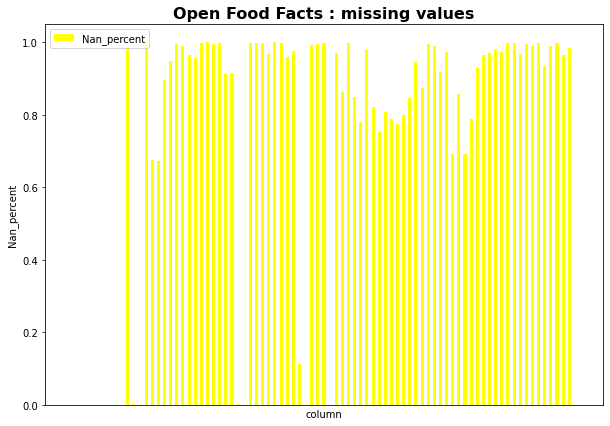

In [5]:
clrs = ['yellow' for x in na_percents["columns_names"].array]
ax = na_percents.plot.bar(x='columns_names', y='Nan_percent', rot=0, figsize=(10,7), color=clrs)
ax.set_title("Open Food Facts : missing values", fontweight="bold", fontsize=16)
ax.set_xlabel("column")
ax.set_ylabel("Nan_percent")
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)

<h3>Inputting missing values for columns finishing by "_100g".</h3>
<p>The replacement of missing values is done by the averages of products' categories in the base.</p>

In [6]:
#Filling missing values in 100_g columns.
data = df_fill_missing_values(data, 'categories')

<h3>Inputting missing values for the column "additives_n".</h3>
<p>The replacement is done by a KNN classifier trained with the "_100g" columns features.</p>

In [7]:
#Obtaining data to train de Knn classifier.
X_data_Knn, y_data_Knn = obtaining_X_y_sets_for_additives_inputting(data)

#Traing a Knn classifier with the available data.
classifier = training_kkn_class_for_inputting(X_data_Knn, y_data_Knn, 15)

#Filling missing values in the additives_n column of the dataframe.
data = filling_missing_values_additives_with_knn_classifier(data,classifier)

In [8]:
#Check the missing values in columns.
na_percents = cal_nan_percents(data)
na_percents

columns_names  Nan_percent
0                                   code          0.0
1                           product_name          0.0
2                             categories          0.0
3                        categories_tags          0.0
4                          categories_en          0.0
5                              countries          0.0
6                         countries_tags          0.0
7                           countries_en          0.0
8                       ingredients_text          0.0
9                            additives_n          0.0
10                    nutrition_grade_fr          0.0
11                      main_category_en          0.0
12                           energy_100g          0.0
13                  energy-from-fat_100g          0.0
14                              fat_100g          0.0
15                    saturated_fat_100g          0.0
16                  -arachidic-acid_100g          0.0
17              monounsaturated-fat_100g          0.0
18              polyunsaturated-fat_100g          0.0
19                      omega-3-fat_100g          0.0
20            -alpha-linolenic-acid_100g          0.0
21           -eicosapentaenoic-acid_100g          0.0
22            -docosahexaenoic-acid_100g          0.0
23                      omega-6-fat_100g          0.0
24                   -linoleic-acid_100g          0.0
25                -arachidonic-acid_100g          0.0
26            -gamma-linolenic-acid_100g          0.0
27                      omega-9-fat_100g          0.0
28                      -oleic-acid_100g          0.0
29                        trans_fat_100g          0.0
30                      cholesterol_100g          0.0
31                    carbohydrates_100g          0.0
32                           sugars_100g          0.0
33                         -sucrose_100g          0.0
34                         -glucose_100g          0.0
35                        -fructose_100g          0.0
36                         -lactose_100g          0.0
37                         -maltose_100g          0.0
38                   -maltodextrins_100g          0.0
39                           starch_100g          0.0
40                          polyols_100g          0.0
41                            fiber_100g          0.0
42                         proteins_100g          0.0
43                           casein_100g          0.0
44                   serum-proteins_100g          0.0
45                      nucleotides_100g          0.0
46                           sodium_100g          0.0
47                          alcohol_100g          0.0
48                        vitamin_a_100g          0.0
49                    beta-carotene_100g          0.0
50                        vitamin-d_100g          0.0
51                        vitamin-e_100g          0.0
52                        vitamin-k_100g          0.0
53                        vitamin_c_100g          0.0
54                       vitamin-b1_100g          0.0
55                       vitamin-b2_100g          0.0
56                       vitamin-pp_100g          0.0
57                       vitamin-b6_100g          0.0
58                       vitamin-b9_100g          0.0
59                      vitamin-b12_100g          0.0
60                           biotin_100g          0.0
61                 pantothenic-acid_100g          0.0
62                           silica_100g          0.0
63                      bicarbonate_100g          0.0
64                        potassium_100g          0.0
65                         chloride_100g          0.0
66                          calcium_100g          0.0
67                       phosphorus_100g          0.0
68                             iron_100g          0.0
69                        magnesium_100g          0.0
70                             zinc_100g          0.0
71                           copper_100g          0.0
72                        manganese_100g          0.0
73                         fluo

In [9]:
#Obtain the number of french products, and composal
n_products = len(data["product_name"].unique())
n_compoents = len(obtain_g_columns(data))
print(n_products)
print(n_compoents)

2896
76


<h3>3. Checking aberrant values in data.</h3>
<p>Checking non-negative values in columns finishing by "_100g". Scores are not taken into account.</p>
<p>Products containing exaggerated amounts of sugar. and sodium are deleted.</p>
<p>- The removing process implies a boundary limit, meaning that if certain product contains more than a limit amount in gr, then the product should be deleted from the database.</p>

In [10]:
#Check columns with negative values in rows.
for i in obtain_g_columns(data):
    if(((data[i] < 0).values.any())):
        print(i)

nutrition_score_fr_100g
nutrition_score_uk_100g


In [11]:
#Deleting products having more than 70g of salt and that aren't salt packets.
print(data.shape)
data = df_deleting_aberrants(data, 'sodium_100g', 70.,['Sel','sel','Salt','salt'], True)
print(data.shape)

(3138, 91)
Products to be removed:
Empty DataFrame
Columns: [product_name, sodium_100g]
Index: []
(3138, 91)


In [12]:
#Deleting products having more than 70g of sugar that are not sugar packets.
print(data.shape)
data = df_deleting_aberrants(data, 'sugars_100g', 80.,['Sucre','sucre','Sirop','sirop','Candy','candy','sweets','Sweets','Bonbon','bonbon'], True)
print(data.shape)

(3138, 91)
Products to be removed:
       product_name  sugars_100g
1041  Super Poulain         85.5
1042  Super Poulain         85.5
1055  Super Poulain         85.0
1059  Super Poulain         85.0
(3134, 91)


In [13]:
#Checking products don't have disproportionate amounts of sugar, and sodium.
data[['product_name','sodium_100g','sugars_100g']].head(5)

product_name  sodium_100g  sugars_100g
0                                 5 Légumes     0.015000          0.0
1                          Picot - riz miel     0.010000          8.0
2  Carré à la crème (29,5 % MG) 12 Portions     0.472441          2.0
3                                  Relais 2     0.160000         42.7
4                            Chocolate Chip     0.357000         32.1

<h3>4. Univariate analysis phase.</h3>
<p>Exploring values and trends within each dataframe variable.</p>

In [14]:
#Check data types for columns.
#All 100g columns and scores must be float64. Categorical variables must be object.
data.dtypes

code                                     object
product_name                             object
categories                               object
categories_tags                          object
categories_en                            object
countries                                object
countries_tags                           object
countries_en                             object
ingredients_text                         object
additives_n                             float64
nutrition_grade_fr                       object
main_category_en                         object
energy_100g                             float64
energy-from-fat_100g                    float64
fat_100g                                float64
saturated_fat_100g                      float64
-arachidic-acid_100g                    float64
monounsaturated-fat_100g                float64
polyunsaturated-fat_100g                float64
omega-3-fat_100g                        float64
-alpha-linolenic-acid_100g              

<h3>4.1 Univariate analysis for categorical variables.</h3>
<p>Univariate analisis for object and boolean type columns within the dataframe.<p/>

In [15]:
#Obtain only categorical (object) variables to work on.
df_categorical = data.select_dtypes(include=['object','bool','int64'])
print(df_categorical.shape)
df_categorical.head(5)

(3134, 13)


code                              product_name  \
0  3401562046203                                 5 Légumes   
1  3401562075586                          Picot - riz miel   
2  3263859391218  Carré à la crème (29,5 % MG) 12 Portions   
3  3401596716356                                  Relais 2   
4  0076677100145                            Chocolate Chip   

                                          categories  \
0                      Céréales pour bébé,dès 4 mois   
1                                 Aliments pour bébé   
2  Frais,Produits à tartiner,Produits à tartiner ...   
3  Aliments pour bébé,Laits pour bébé,Laits 2ème âge   
4  Sugary snacks,Biscuits and cakes,Biscuits,Cookies   

                                     categories_tags  \
0  en:baby-foods,en:cereals-for-babies,en:from-4-...   
1                                      en:baby-foods   
2  en:fresh-foods,en:spreads,en:salted-spreads,en...   
3      en:baby-foods,en:baby-milks,fr:laits-2eme-age   
4  en:sugary-snacks,en:biscuits-and-cakes,en:bisc...   

                                       categories_en  \
0        Baby foods,Cereals for babies,From 4 months   
1                                         Baby foods   
2  Fresh foods,Spreads,Salted spreads,Dairies,Che...   
3            Baby foods,Baby milks,fr:Laits 2ème âge   
4  Sugary snacks,Biscuits and cakes,Biscuits,Cookies   

                  countries              countries_tags          countries_en  \
0                    France                   en:france                France   
1                    France                   en:france                France   
2                    France                   en:france                France   
3                    France                   en:france                France   
4  United States, en:france  en:france,en:united-states  France,United States   

                                    ingredients_text nutrition_grade_fr  \
0  Crème de riz (40,5%), maltodextrines, farine d...                  b   
1  Crème de riz (64%), maltodextrines, fructose, ...                  b   
2  Fromage blanc (dont _lait_ 38 %), _crème_ (27 ...                  d   
3  Lactose, maltodextrines, crème, lait écrémé, h...                  e   
4  ENRICHED FLOUR (_WHEAT_ FLOUR), NIACIN, REDUCE...                  e   

  main_category_en  in_france  sum_healthy_composals  
0       Baby foods       True                      4  
1       Baby foods       True                      1  
2      Fresh foods       True                      1  
3       Baby foods       True                      1  
4    Sugary snacks       True                      1

<h3>Box plots for topest 20 categories in categorical variables.</h3>
<p>Depicting visually the distribution of categories within categorical variables.</p>

<Figure size 432x288 with 0 Axes>

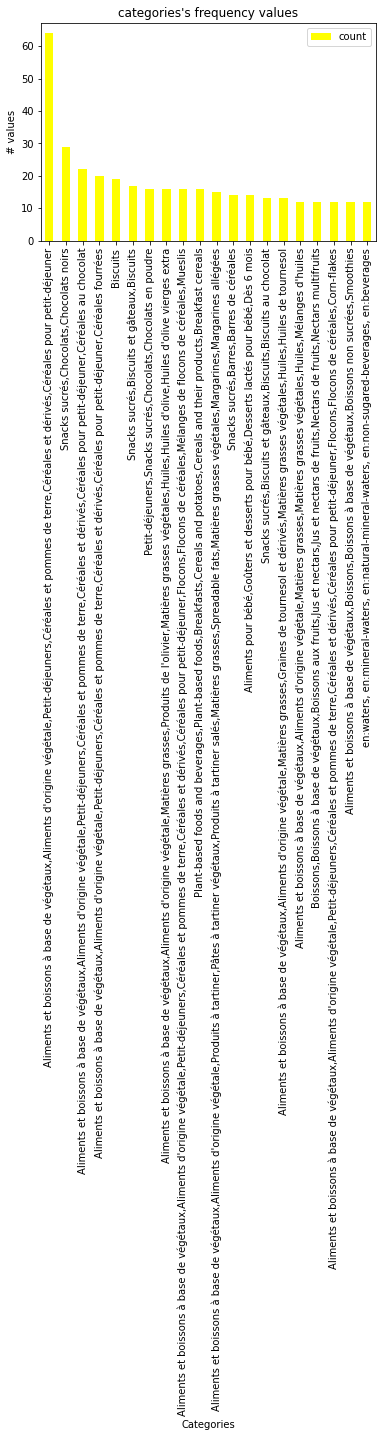

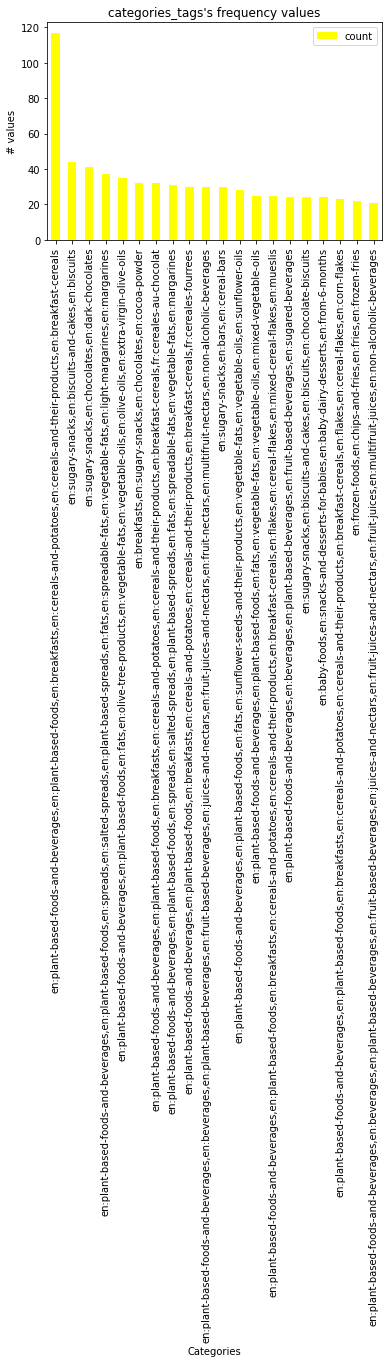

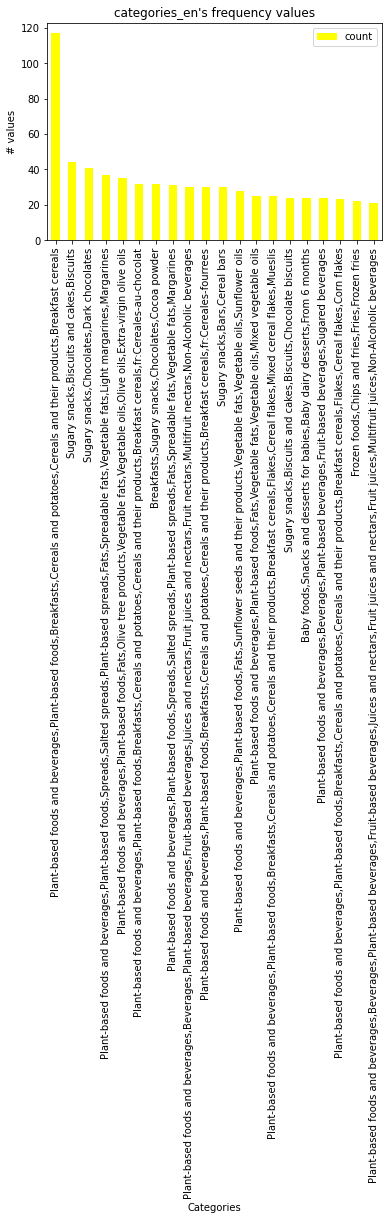

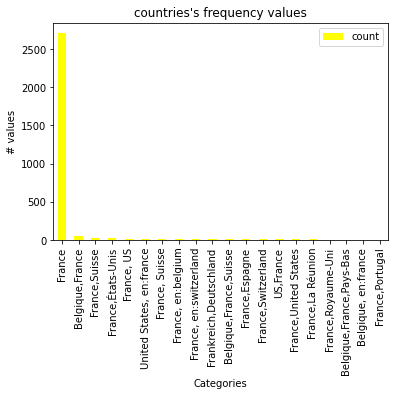

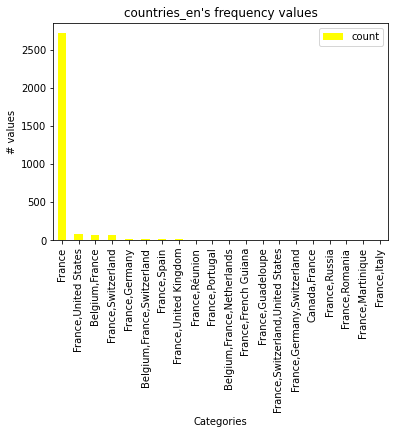

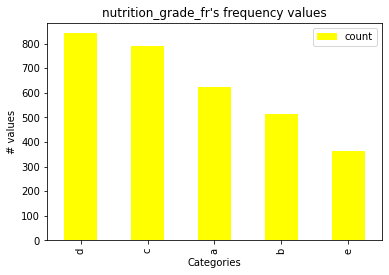

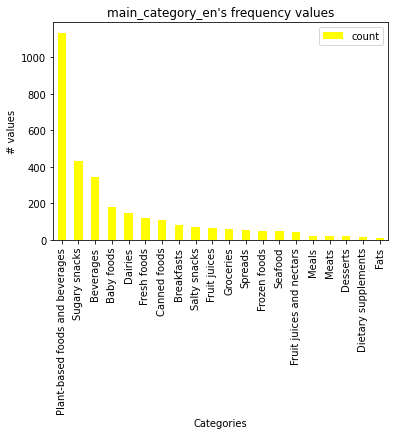

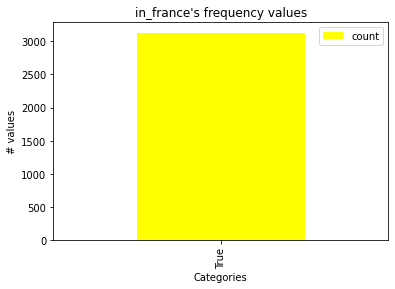

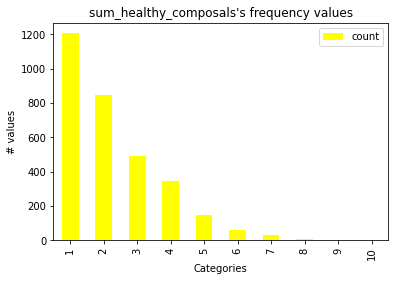

In [16]:
plots_univariate_analysis_categorical_variables(df_categorical)

<h3>Pie charts for topest 10 categories in categorical variables.</h3>
<p>The open food facts file is stored as a dask object due to its size.</p>

/home/juan-david/.local/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1547: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  results = ax.pie(y, labels=blabels, **kwds)
/home/juan-david/.local/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1547: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  results = ax.pie(y, labels=blabels, **kwds)


<Figure size 432x288 with 0 Axes>

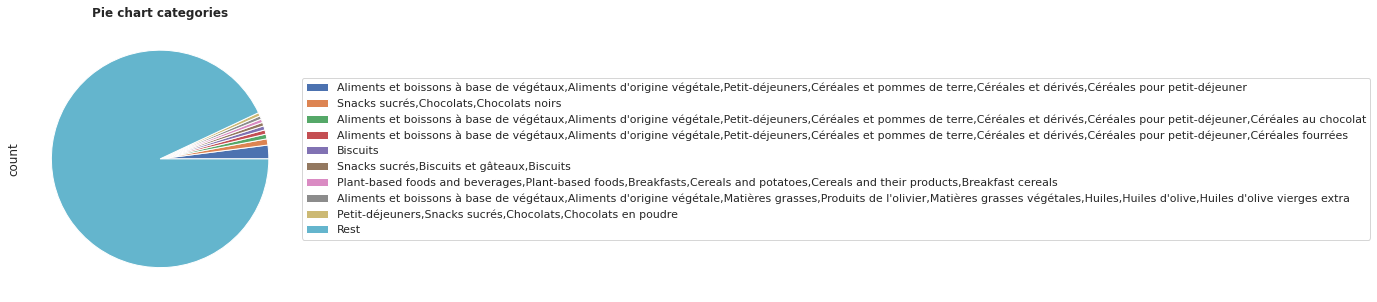

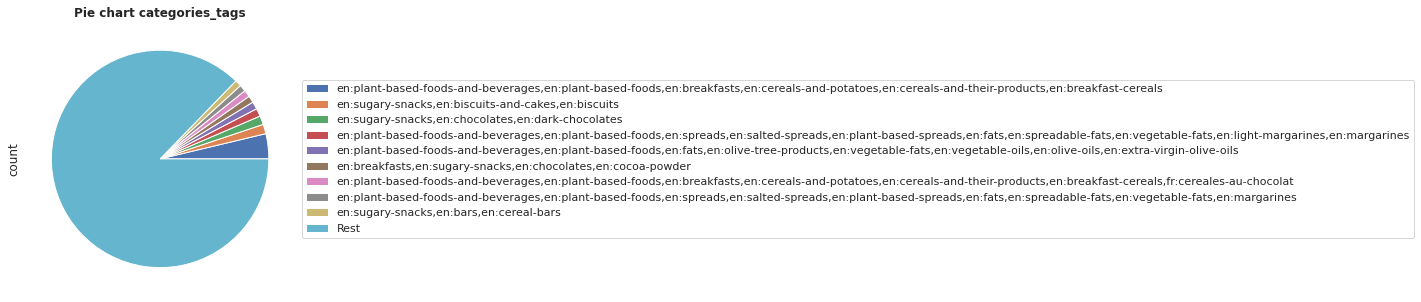

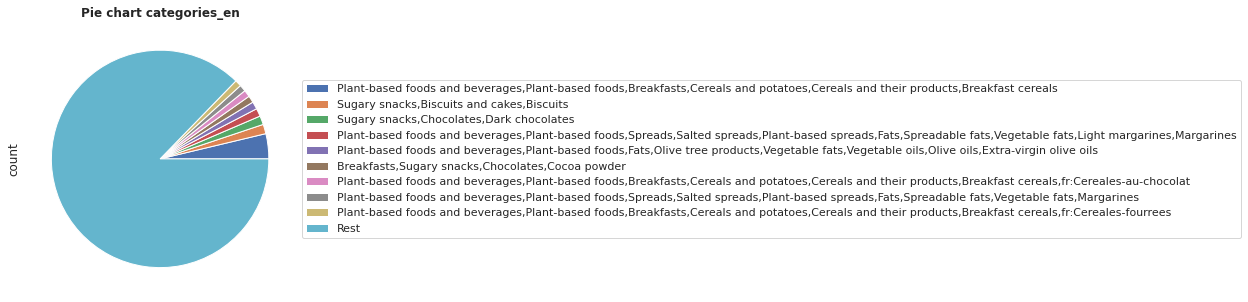

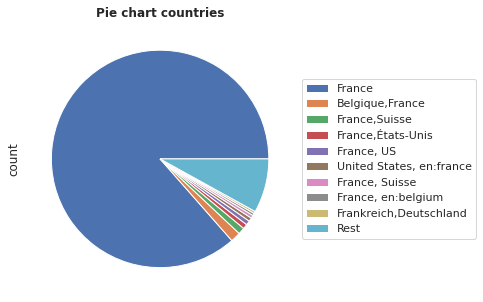

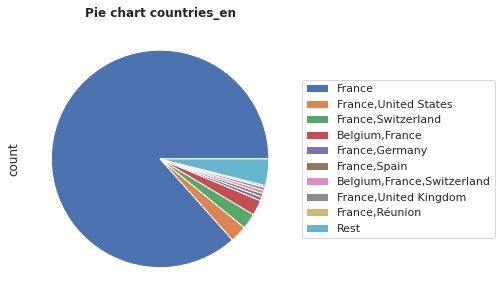

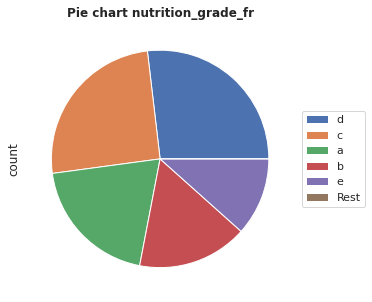

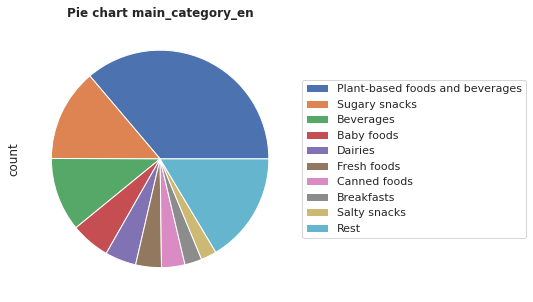

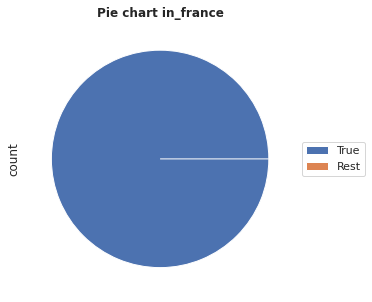

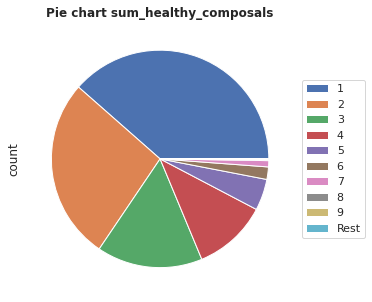

In [17]:
univariate_analysis_pie_chart_categorical_columns(df_categorical)

<h3>4.2 Univariate analysis for real variables.</h3>
<p>Univariate analisis for float64 variables within the dataframe.</p>

In [18]:
#Obtain only real(float64) variables.
df_real = data.select_dtypes(include=[np.float])
df_real_columns = df_real.columns
print(df_real.shape)
df_real.head(5)

(3134, 78)


additives_n  energy_100g  energy-from-fat_100g  fat_100g  \
0          3.0       1612.0                   0.0       0.2   
1          3.0       1586.0                   0.0       0.2   
2          4.0       1289.0                   0.0      30.0   
3         13.0       2139.0                   0.0      26.6   
4          3.0       2090.0                 896.0      23.2   

   saturated_fat_100g  -arachidic-acid_100g  monounsaturated-fat_100g  \
0                0.00                   0.0                       0.0   
1                0.00                   0.0                       0.0   
2               21.00                   0.0                       0.0   
3               11.40                   0.0                       0.0   
4                8.93                   0.0                       0.0   

   polyunsaturated-fat_100g  omega-3-fat_100g  -alpha-linolenic-acid_100g  \
0                       0.0               0.0                        0.00   
1                       0.0               0.0                        0.05   
2                       0.0               0.0                        0.00   
3                       0.0               0.0                        0.60   
4                       0.0               0.0                        0.00   

   -eicosapentaenoic-acid_100g  -docosahexaenoic-acid_100g  omega-6-fat_100g  \
0                          0.0                         0.0               0.0   
1                          0.0                         0.0               0.0   
2                          0.0                         0.0               0.0   
3                          0.0                         0.0               0.0   
4                          0.0                         0.0               0.0   

   -linoleic-acid_100g  -arachidonic-acid_100g  -gamma-linolenic-acid_100g  \
0                0.000                     0.0                         0.0   
1                0.531                     0.0                         0.0   
2                0.000                     0.0                         0.0   
3                3.600                     0.0                         0.0   
4                0.000                     0.0                         0.0   

   omega-9-fat_100g  -oleic-acid_100g  trans_fat_100g  cholesterol_100g  \
0               0.0               0.0             0.0           0.00000   
1               0.0               0.0             0.0           0.00000   
2               0.0               0.0             0.0           0.00000   
3               0.0               0.0             0.0           0.00000   
4               0.0               0.0             0.0           0.00893   

   carbohydrates_100g  sugars_100g  -sucrose_100g  -glucose_100g  \
0                89.5          0.0            0.0            0.0   
1                88.9          8.0            0.0            0.0   
2                 2.0          2.0            0.0            0.0   
3                57.5         42.7            0.0            0.0   
4                67.9         32.1            0.0            0.0   

   -fructose_100g  -lactose_100g  -maltose_100g  -maltodextrins_100g  \
0             0.0            0.0            0.0                  0.0   
1             0.0            0.0            0.0                  0.0   
2             0.0            0.0            0.0                  0.0   
3             0.0           40.4            0.0                 14.8   
4             0.0            0.0            0.0                  0.0   

   starch_100g  polyols_100g  fiber_100g  proteins_100g  casein_100g  \
0          0.0           0.0        1.90           4.00          0.0   
1          0.0           0.0        0.90           5.00          0.0   
2          0.0           0.0        0.00           8.50          0.0   
3         14.8           0.0        0.00          10.40          4.2   
4          0.0           0.0        3.57           5.36          0.0   

   serum-proteins_100g  nucleotides_100g  sodi

In [19]:
#Desccribe real variables in dataframe.
df_real.describe()

additives_n  energy_100g  energy-from-fat_100g     fat_100g  \
count  3134.000000  3134.000000           3134.000000  3134.000000   
mean      2.380345  1311.523290             26.467422    17.258642   
std       2.790746   949.382758            174.814366    24.924311   
min       0.000000     0.000000              0.000000     0.000000   
25%       0.000000   357.250000              0.000000     1.700000   
50%       2.000000  1495.500000              0.000000     6.450000   
75%       4.000000  1900.000000              0.000000    21.300000   
max      18.000000  3925.000000           1830.000000   100.000000   

       saturated_fat_100g  -arachidic-acid_100g  monounsaturated-fat_100g  \
count         3134.000000           3134.000000               3134.000000   
mean             4.585721              0.000041                  6.182202   
std              7.077505              0.001617                 13.715197   
min              0.000000              0.000000                  0.000000   
25%              0.300000              0.000000                  0.000000   
50%              1.600000              0.000000                  0.000000   
75%              6.100000              0.000000                  6.350000   
max             91.000000              0.064000                 80.000000   

       polyunsaturated-fat_100g  omega-3-fat_100g  -alpha-linolenic-acid_100g  \
count               3134.000000       3134.000000                 3134.000000   
mean                   3.656492          0.525581                    0.185462   
std                    9.859974          2.065921                    1.846817   
min                    0.000000          0.000000                    0.000000   
25%                    0.000000          0.000000                    0.000000   
50%                    0.000000          0.000000                    0.000000   
75%                    2.855556          0.000000                    0.000000   
max                   75.000000         38.200000                   75.000000   

       -eicosapentaenoic-acid_100g  -docosahexaenoic-acid_100g  \
count                  3134.000000                 3134.000000   
mean                      0.030418                    0.008333   
std                       1.519208                    0.095395   
min                       0.000000                    0.000000   
25%                       0.000000                    0.000000   
50%                       0.000000                    0.000000   
75%                       0.000000                    0.000000   
max                      85.000000                    3.200000   

       omega-6-fat_100g  -linoleic-acid_100g  -arachidonic-acid_100g  \
count       3134.000000          3134.000000             3134.000000   
mean           1.356497             0.305210                0.000207   
std            6.371386             2.283679                0.003698   
min            0.000000             0.000000                0.000000   
25%            0.000000             0.000000                0.000000   
50%            0.000000             0.000000                0.000000   
75%            0.000000             0.000000                0.000000   
max           71.000000            25.000000                0.090000   

       -gamma-linolenic-acid_100g  omega-9-fat_100g  -oleic-acid_100g  \
count                 3134.000000       3134.000000       3134.000000   
mean                     0.000030          1.160555          0.570692   
std                      0.001697          8.278342          6.251372   
min                      0.000000          0.000000          0.000000   
25%                      0.000000          0.000000          0.000000   
50%                      0.000000          0.000000          0.000000   
75%                      0.000000          0.000000          0.000000   
max                      0.095000         75.000000         76.000000   

       trans_fat_100g  cholesterol_100g  carbohydr

<h3>Box plots for real variables.</h3>
<p>Depicting box plots for real variables within the dataframe.</p>

/home/juan-david/Documents/data_science/course_openclassrooms/projet_3/livrables/p3_exploration_fonctions_aide.py:247: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(i)


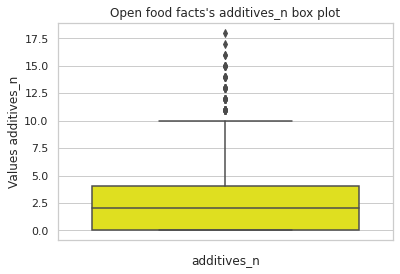

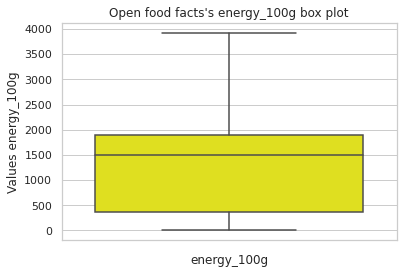

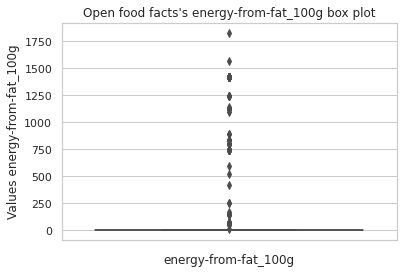

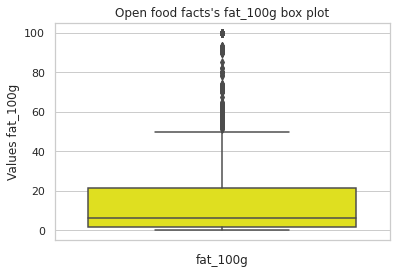

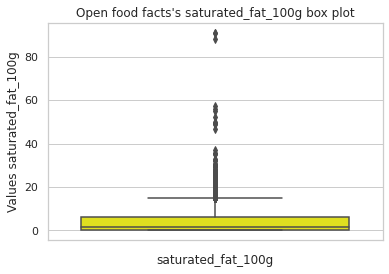

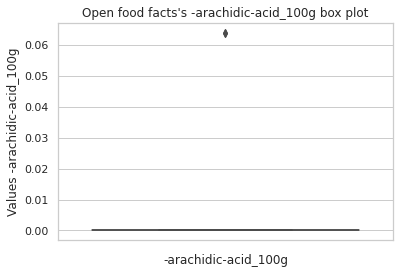

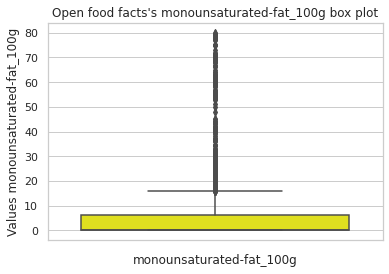

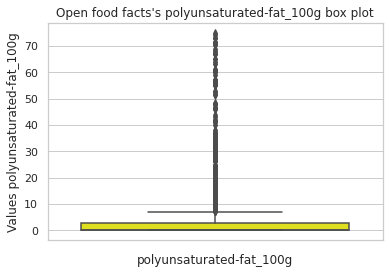

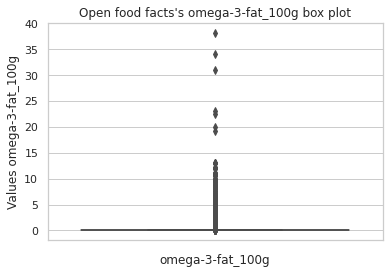

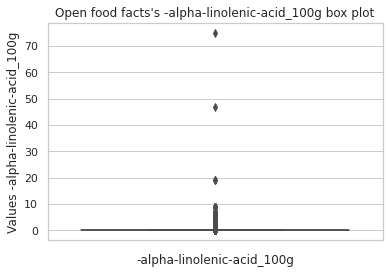

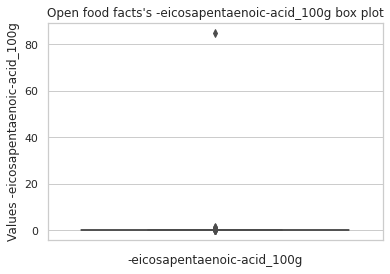

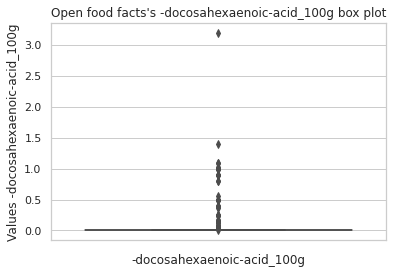

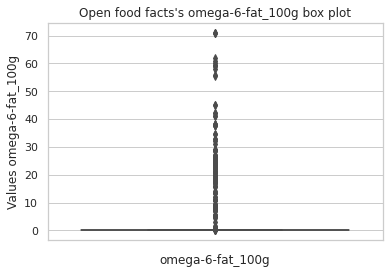

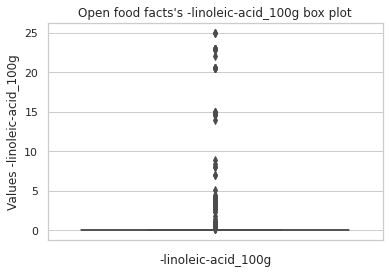

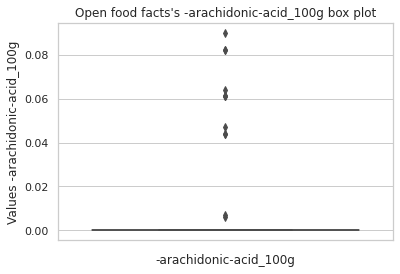

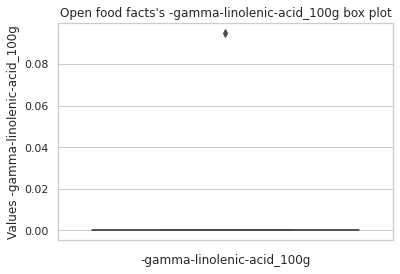

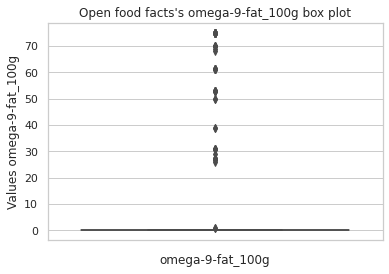

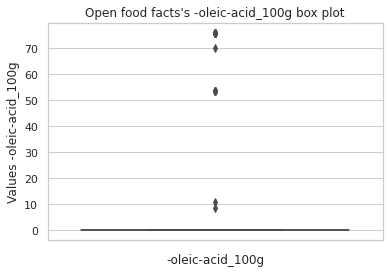

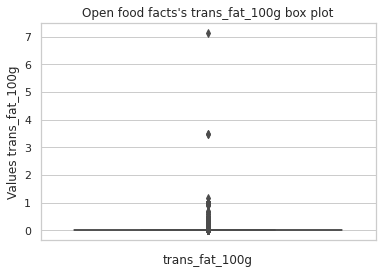

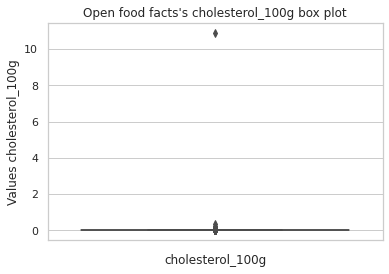

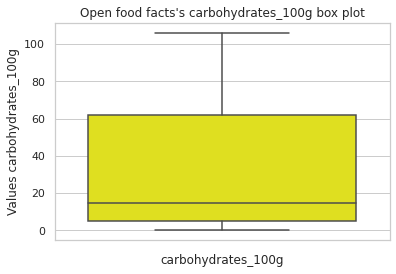

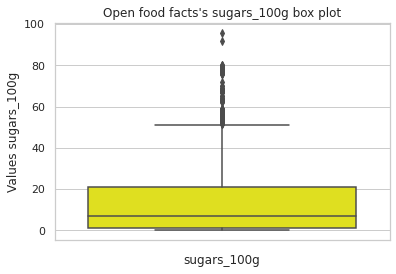

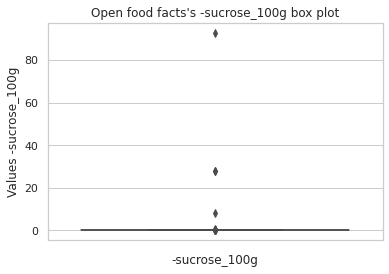

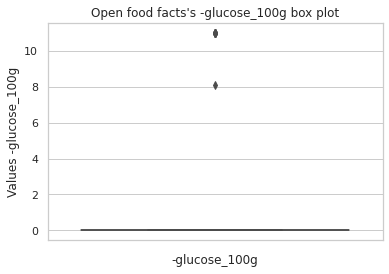

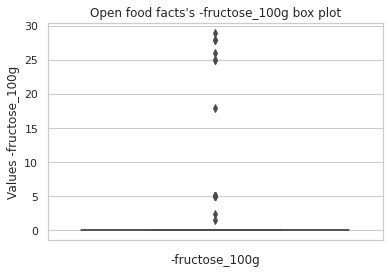

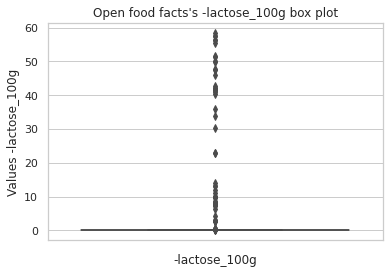

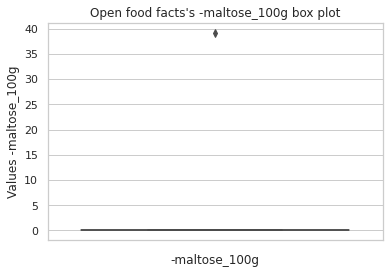

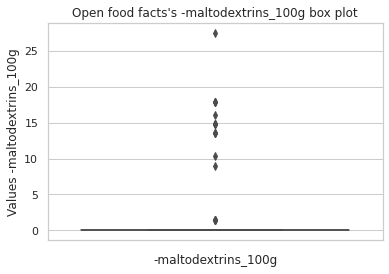

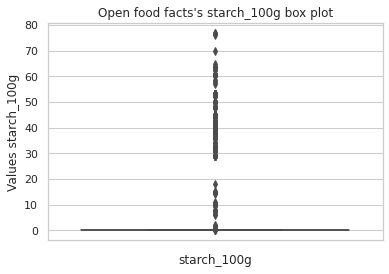

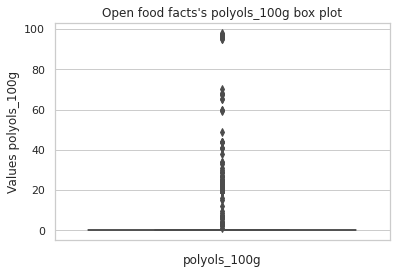

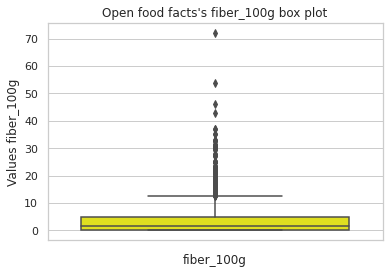

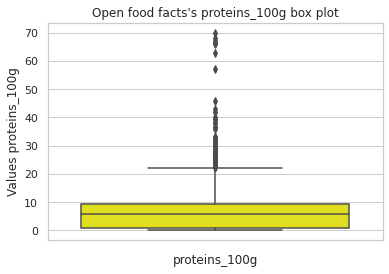

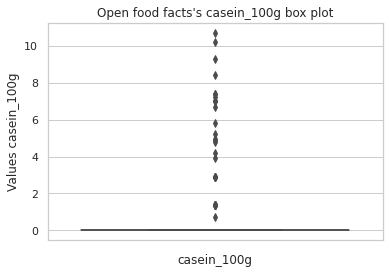

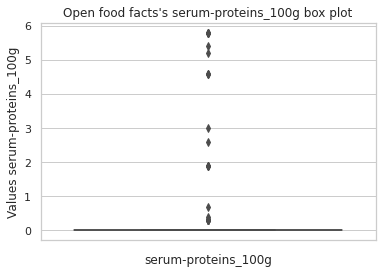

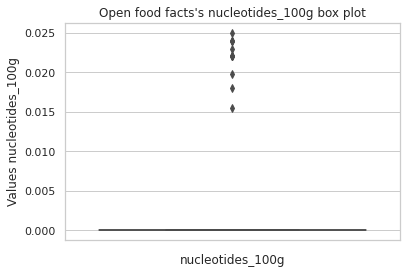

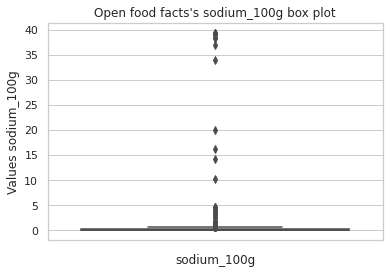

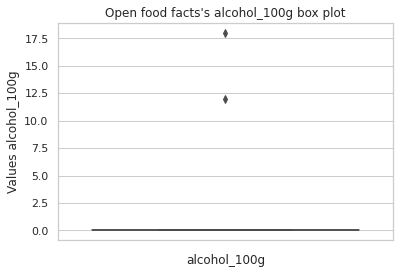

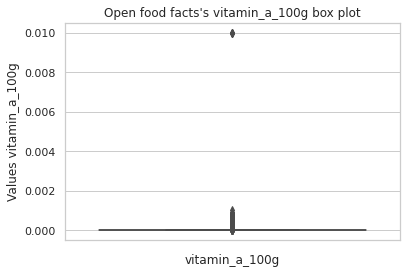

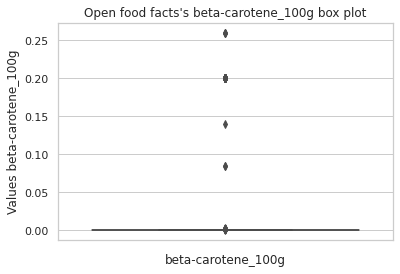

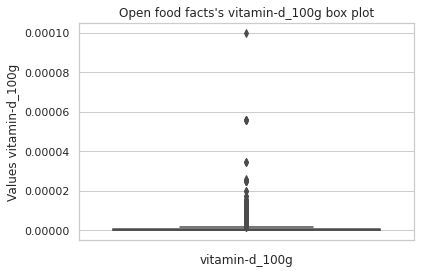

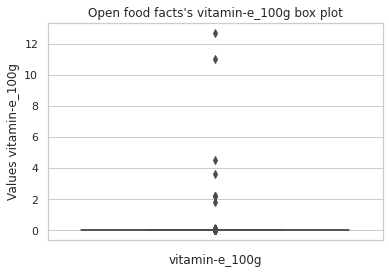

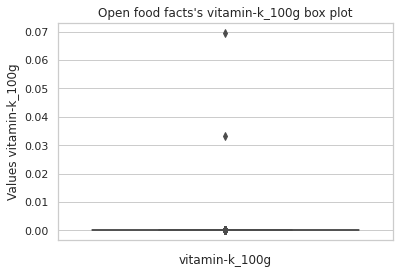

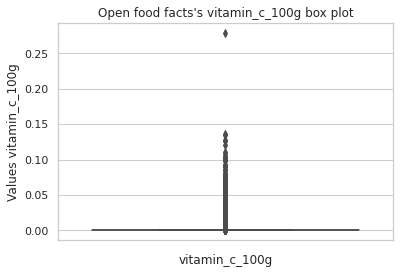

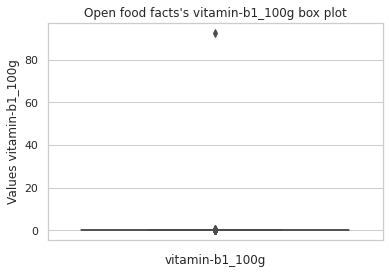

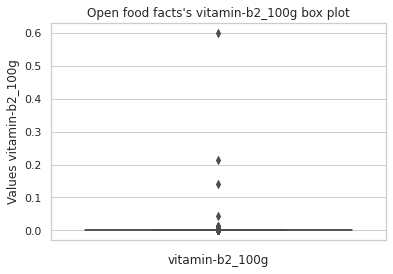

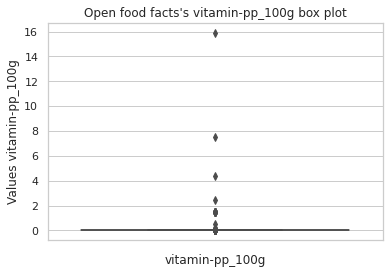

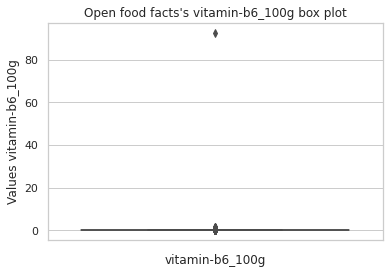

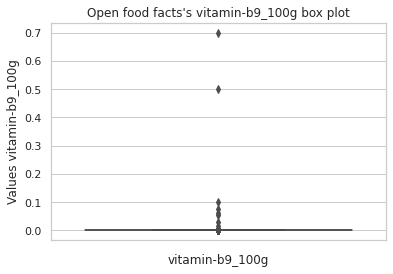

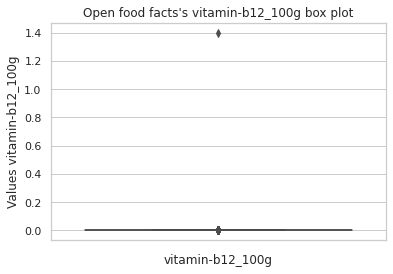

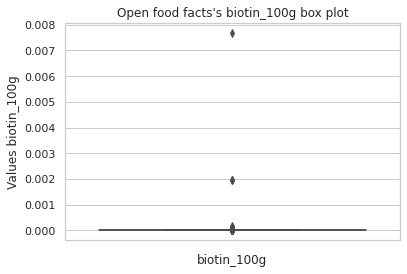

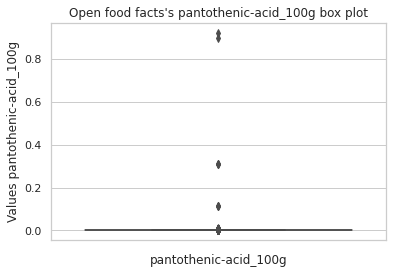

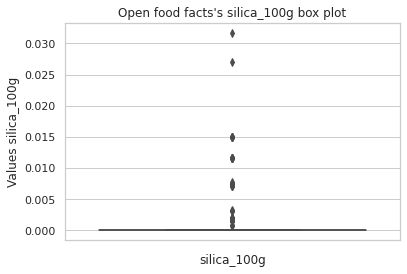

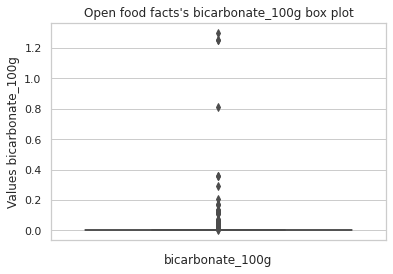

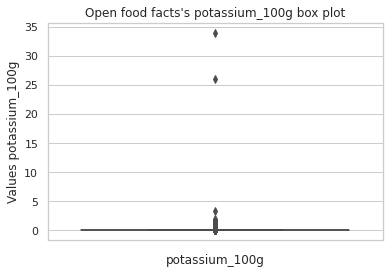

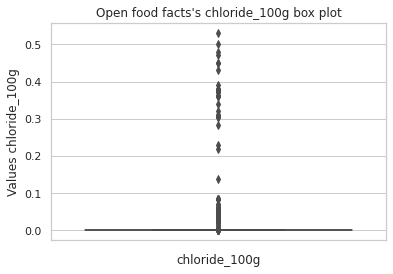

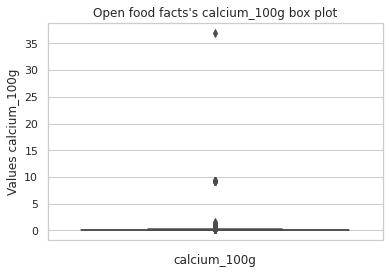

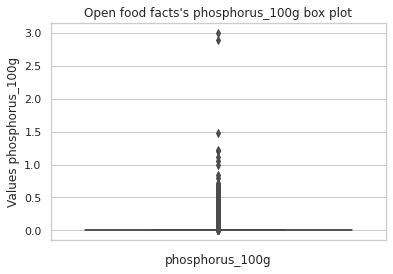

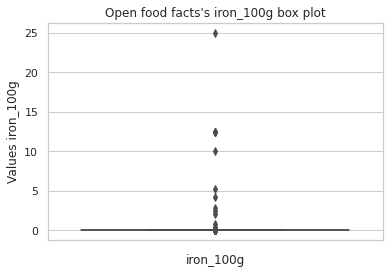

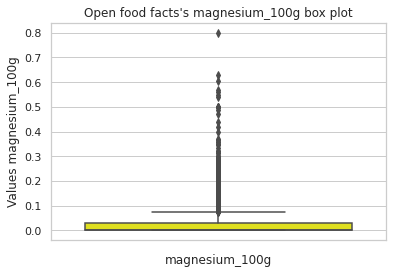

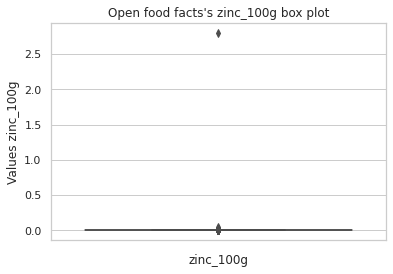

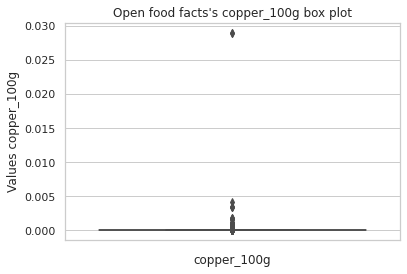

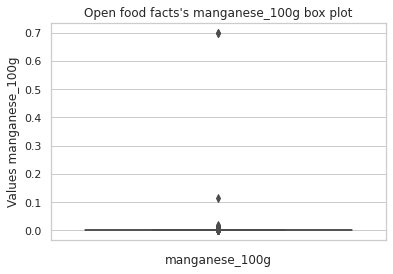

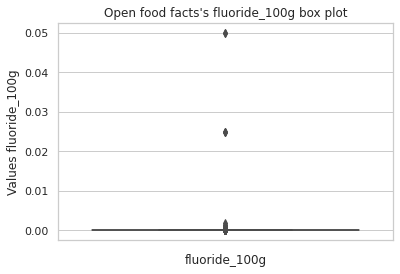

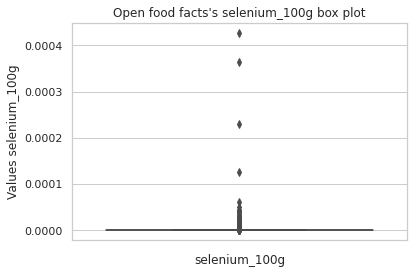

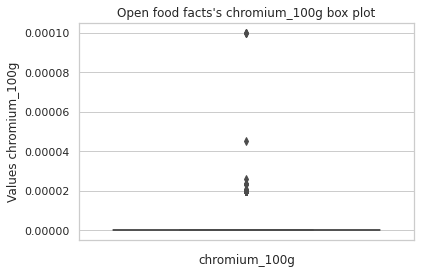

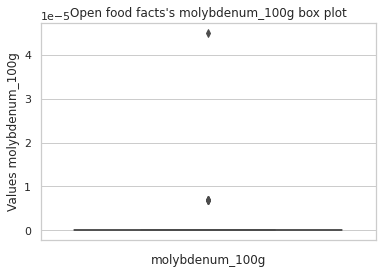

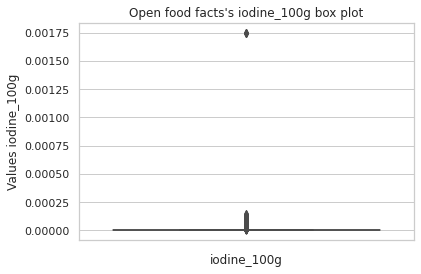

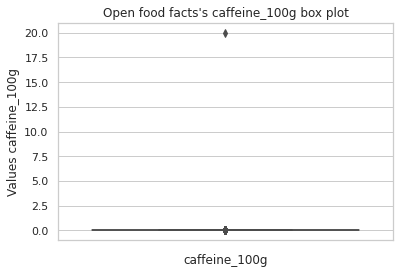

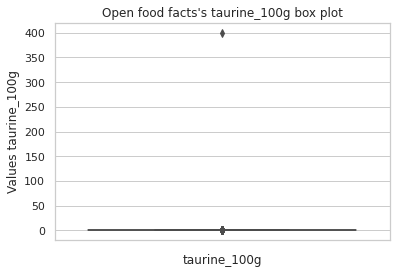

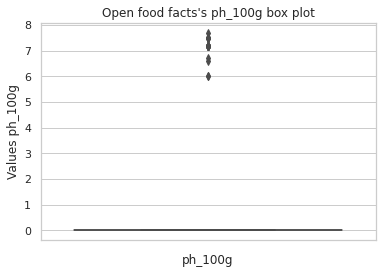

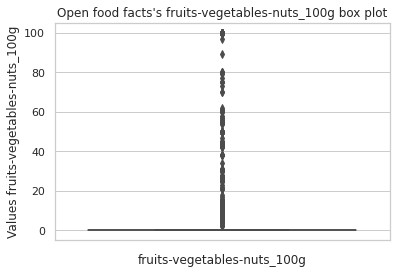

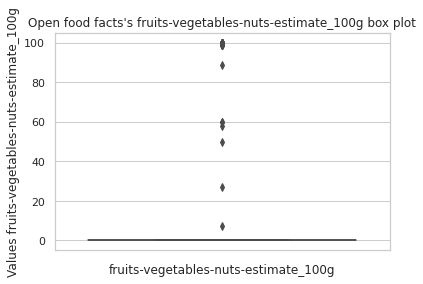

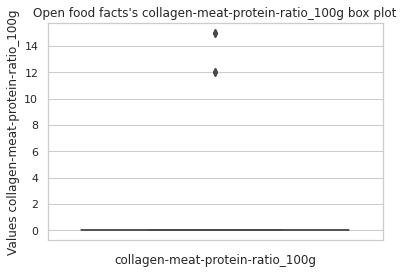

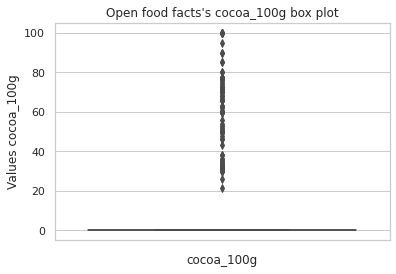

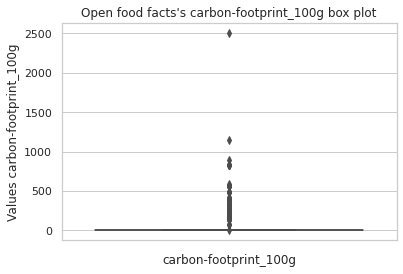

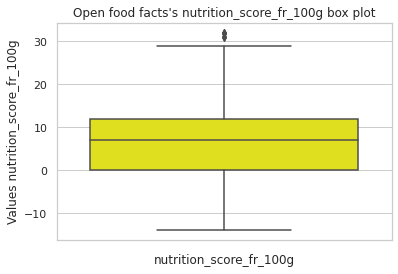

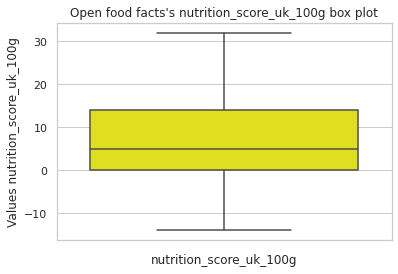

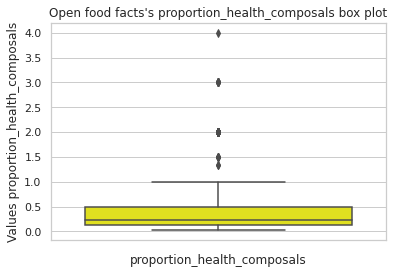

In [20]:
plot_box_plots_real_variables(df_real)

<h3>Histograms for real variables.</h3>
<p>Depicting histograms for real variables within the dataframe.</p>

/home/juan-david/Documents/data_science/course_openclassrooms/projet_3/livrables/p3_exploration_fonctions_aide.py:264: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(i_fig,figsize=(3,3))


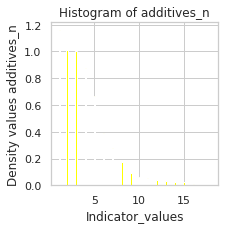

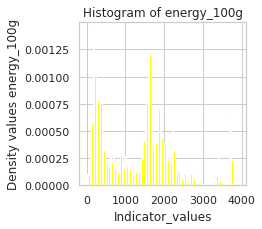

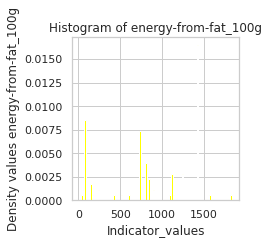

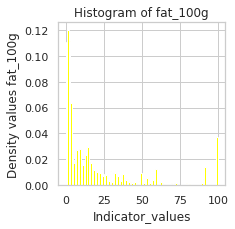

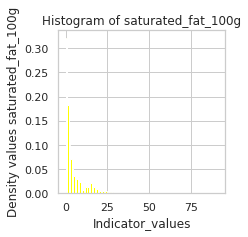

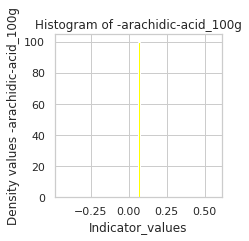

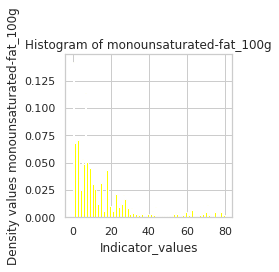

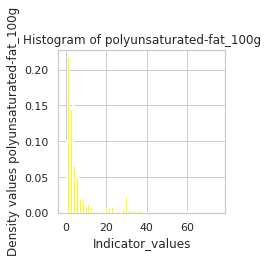

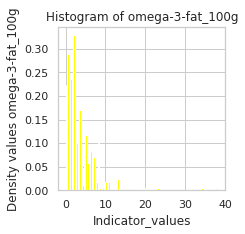

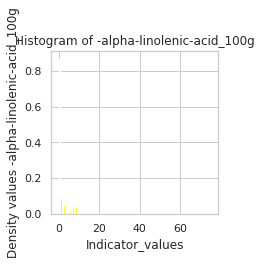

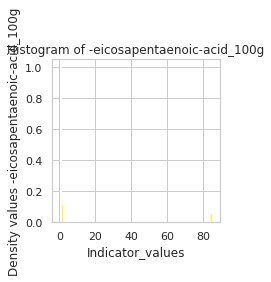

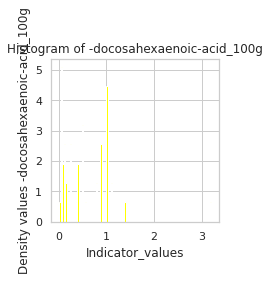

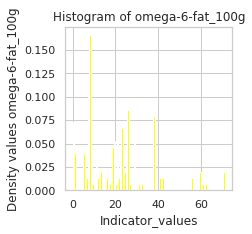

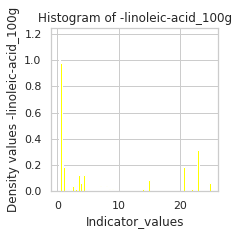

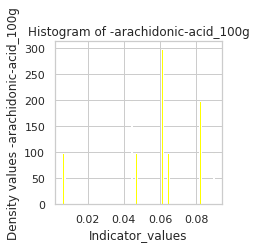

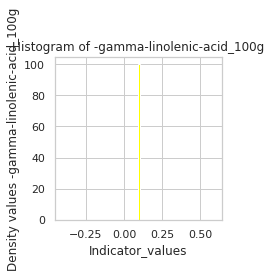

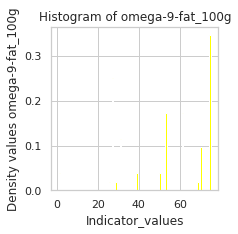

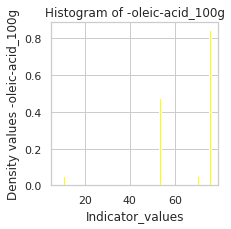

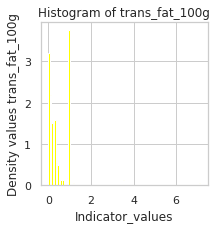

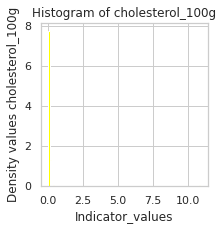

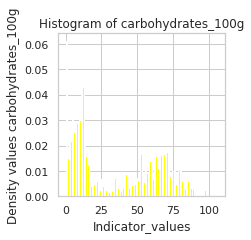

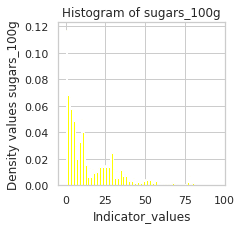

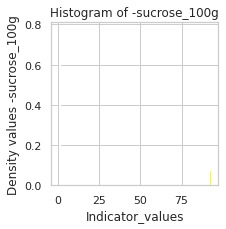

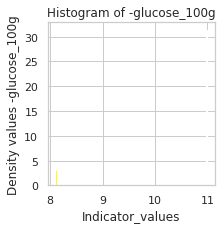

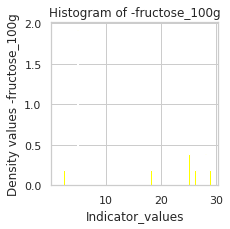

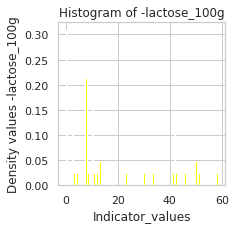

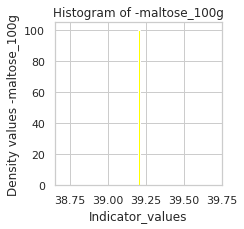

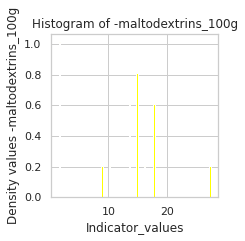

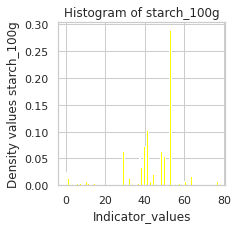

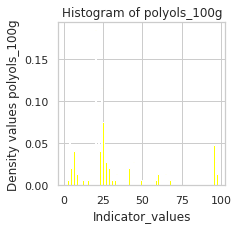

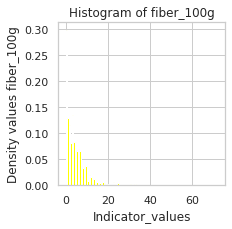

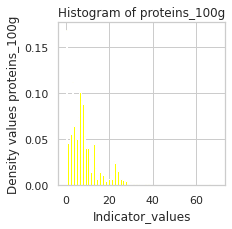

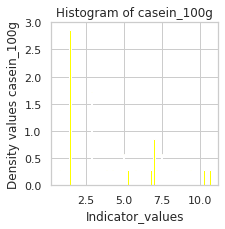

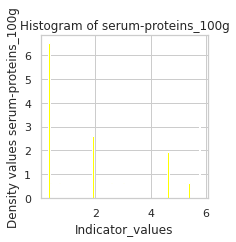

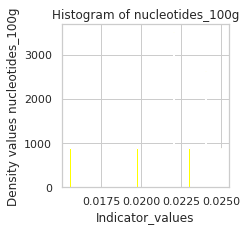

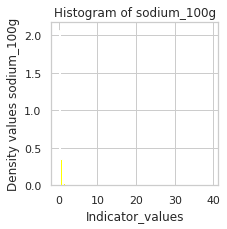

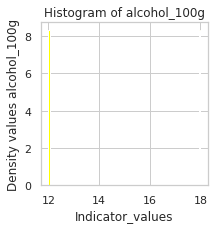

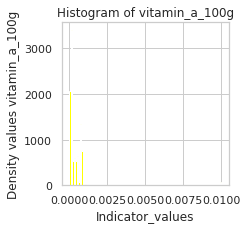

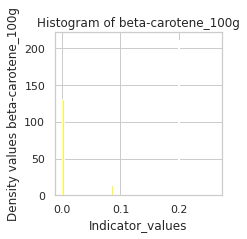

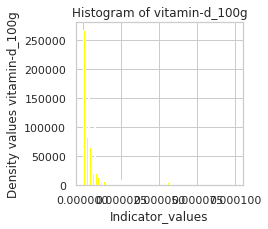

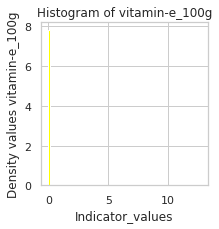

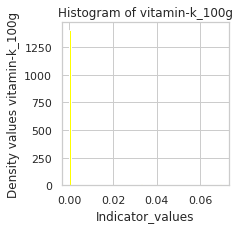

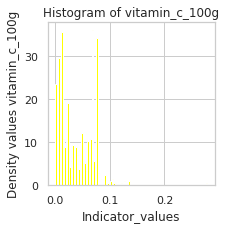

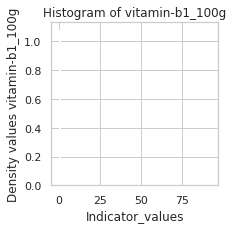

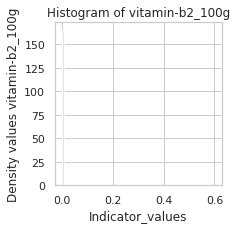

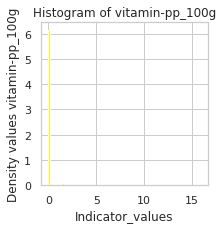

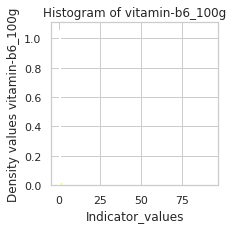

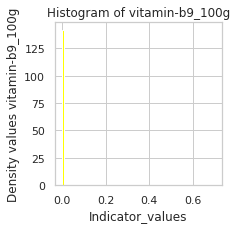

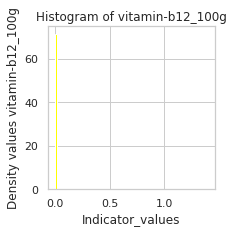

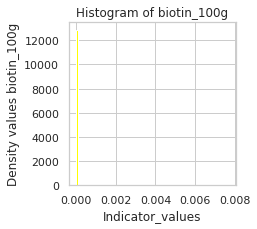

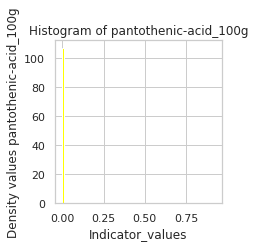

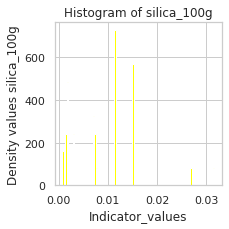

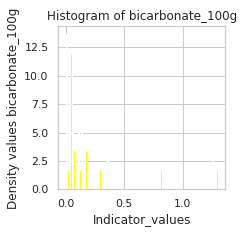

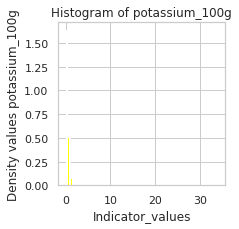

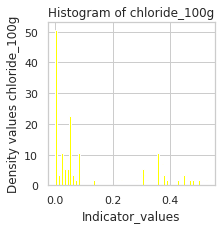

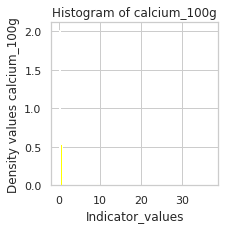

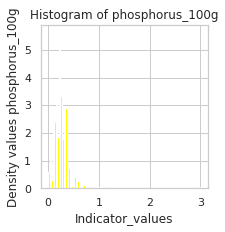

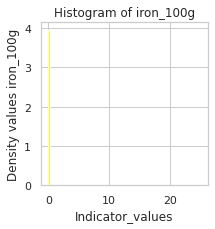

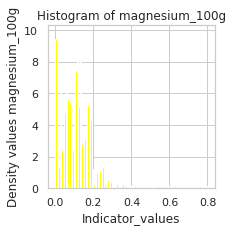

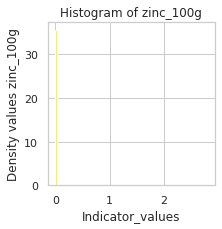

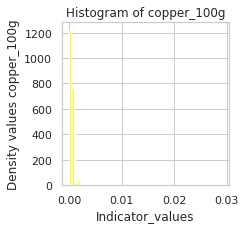

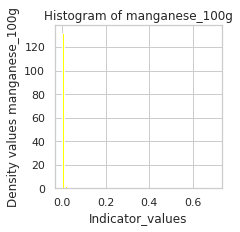

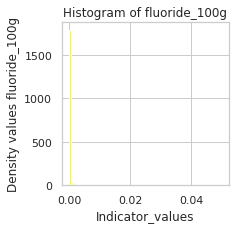

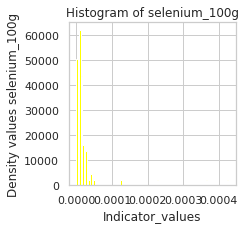

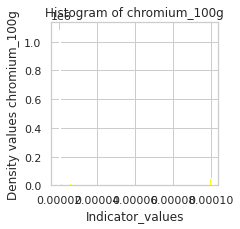

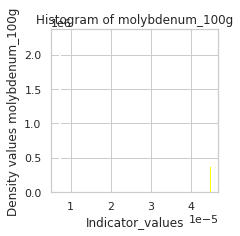

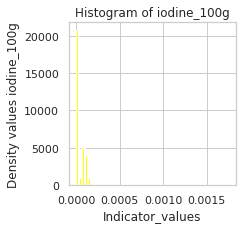

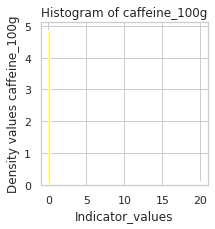

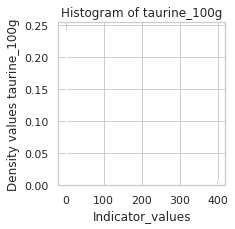

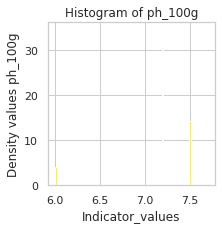

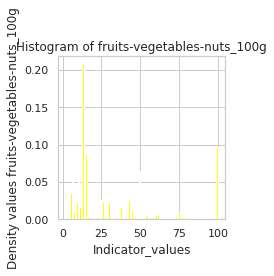

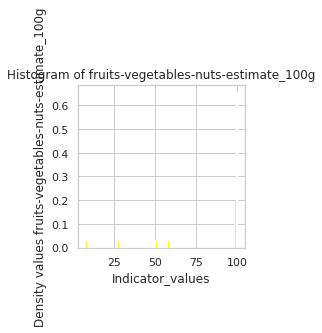

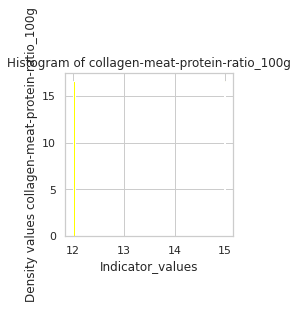

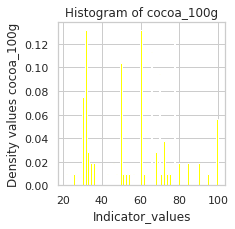

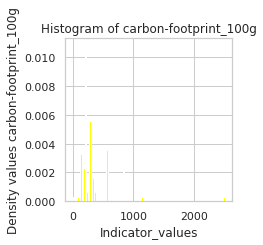

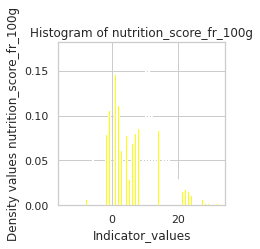

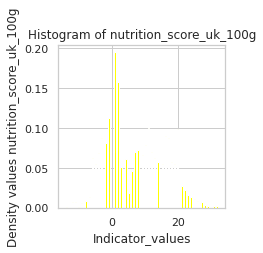

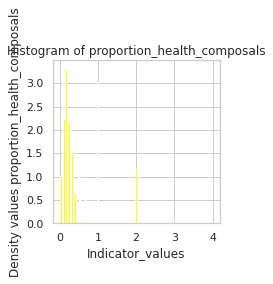

In [21]:
plot_histograms_real_variables(df_real)

<h3>Outlayers' traitment in real variables.</h3>
<p>The open food facts file is stored as a dask object due to its size.</p>

In [22]:
print(df_real.shape)
print(df_categorical.shape)

#Avoiding outlayers by removing concerned rows in real dataframe.
cols_outlayers_treatment = ['monounsaturated-fat_100g','magnesium_100g','polyunsaturated-fat_100g','fat_100g','saturated_fat_100g','sugars_100g','fiber_100g', 'proteins_100g']
#Outlayers are treated and removed from specific columns.
for i in cols_outlayers_treatment:
    df_real = remove_outlayers_base_on_column(df_real,i)

#Update rows removed in the categorical dataframe.
df_categorical = update_df_part_shape(df_categorical, df_real.index)   
print(df_real.shape)
print(df_categorical.shape)

(3134, 78)
(3134, 13)
(1335, 78)
(1335, 13)


/home/juan-david/Documents/data_science/course_openclassrooms/projet_3/livrables/p3_exploration_fonctions_aide.py:247: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(i)


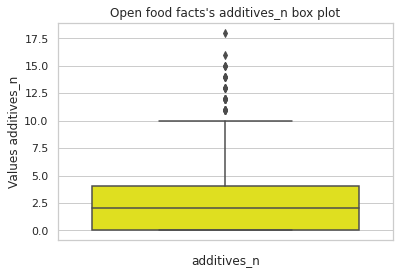

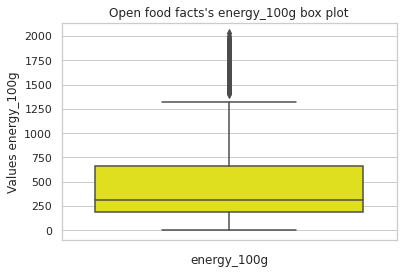

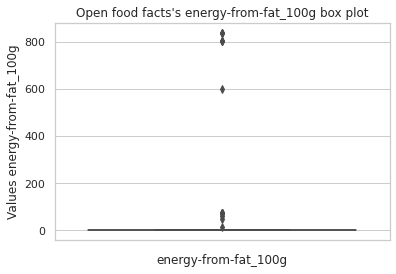

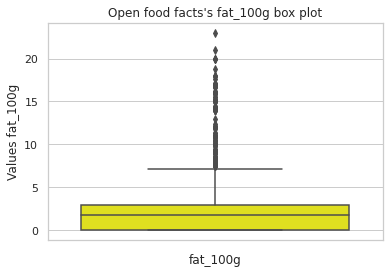

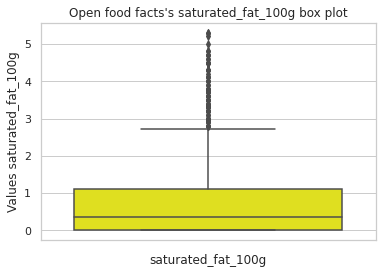

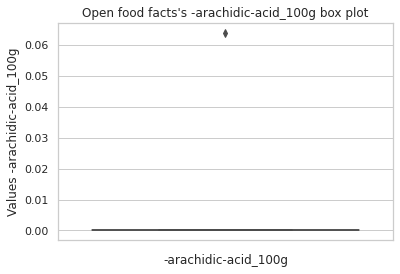

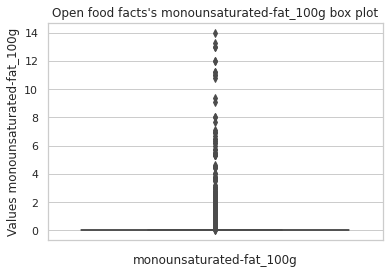

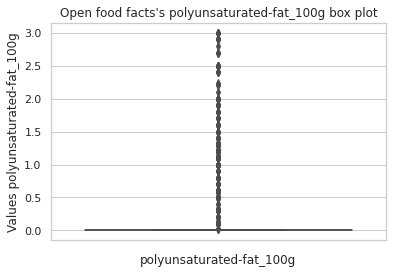

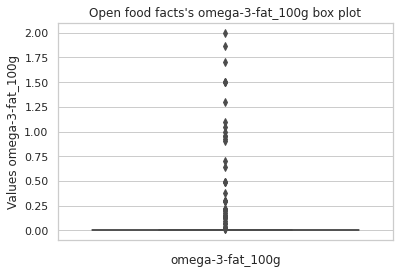

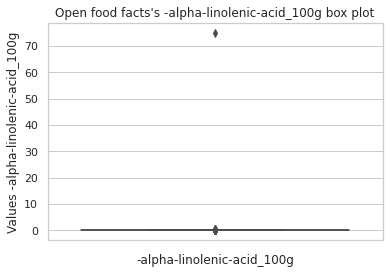

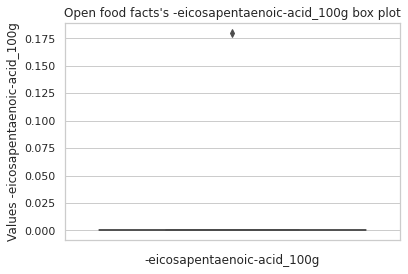

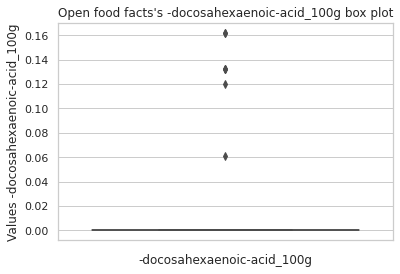

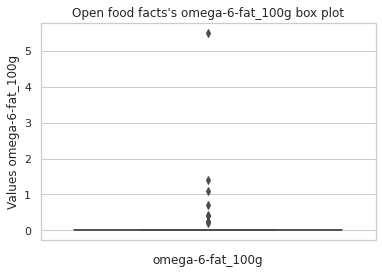

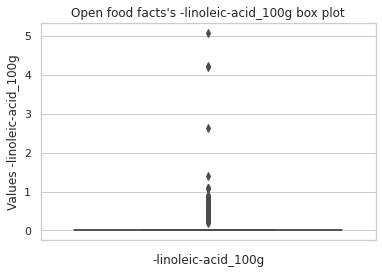

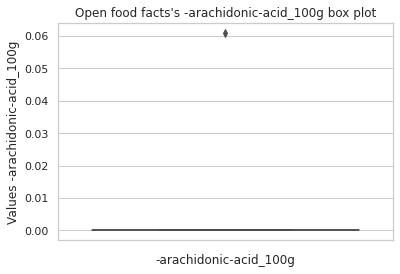

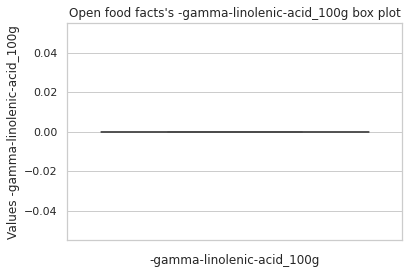

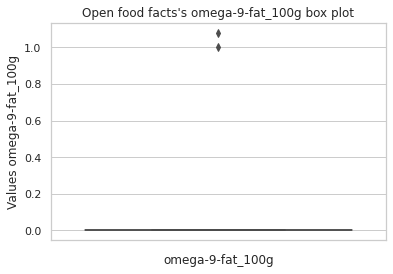

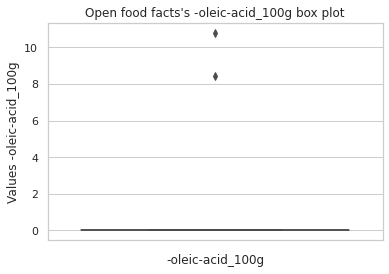

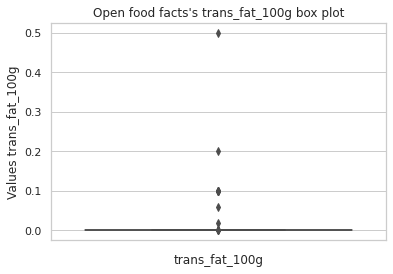

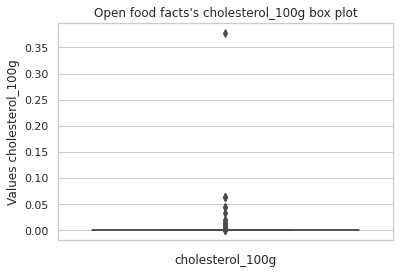

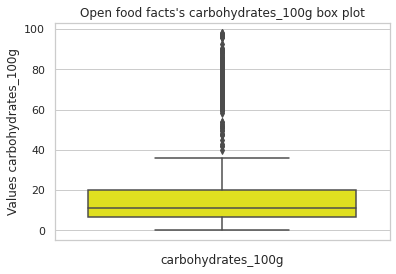

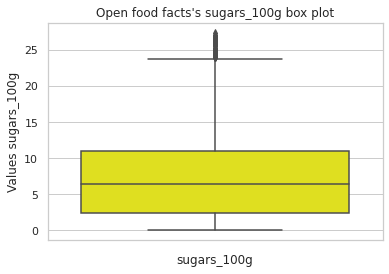

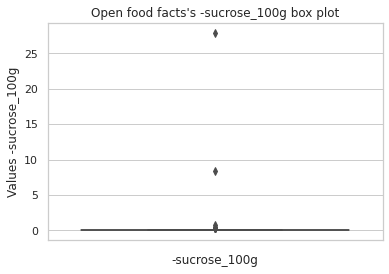

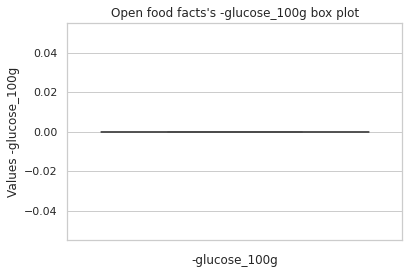

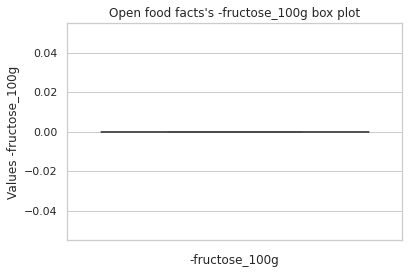

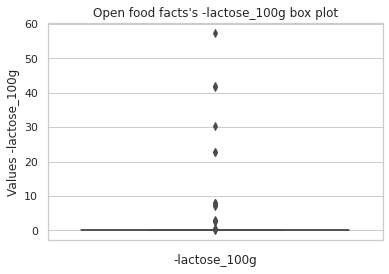

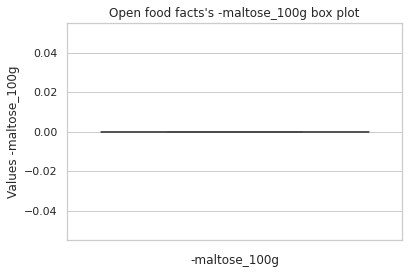

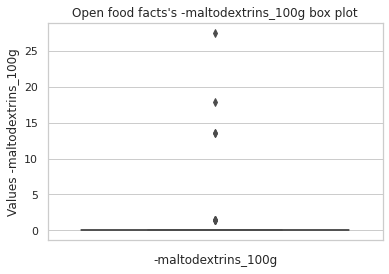

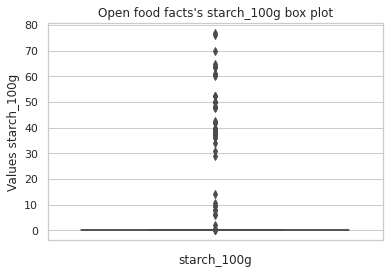

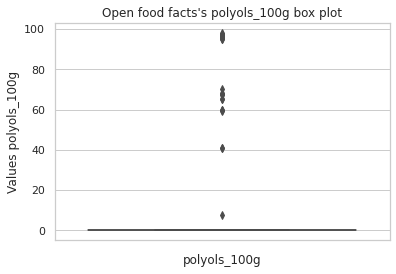

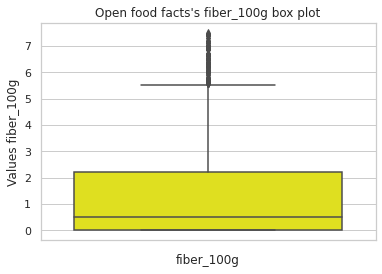

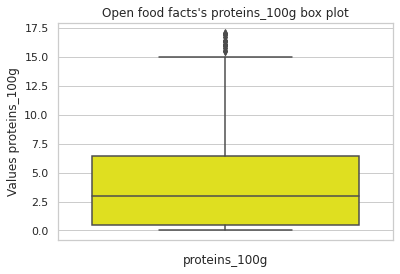

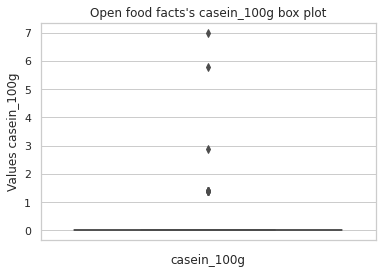

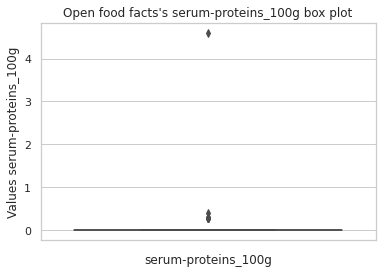

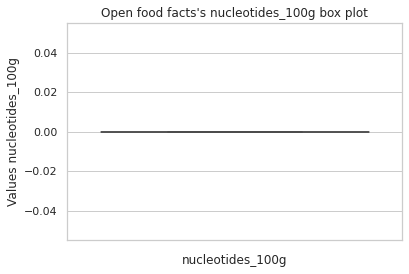

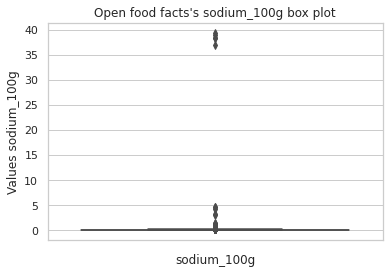

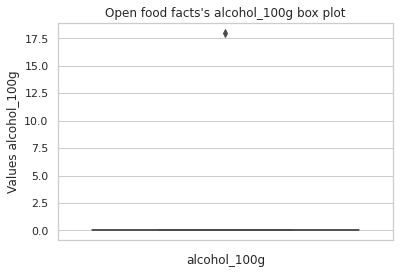

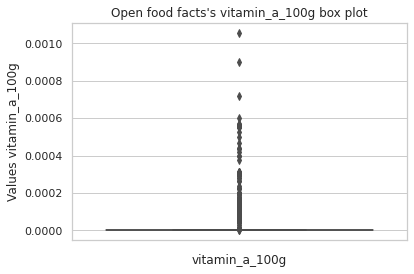

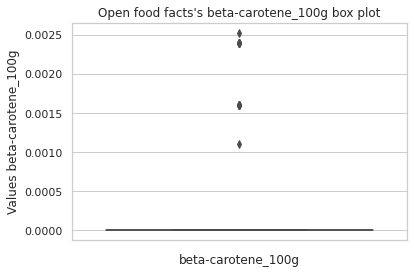

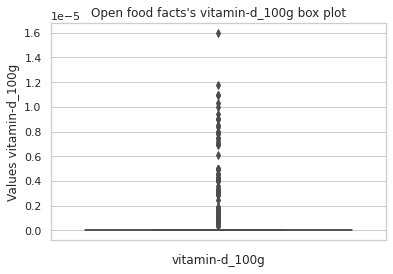

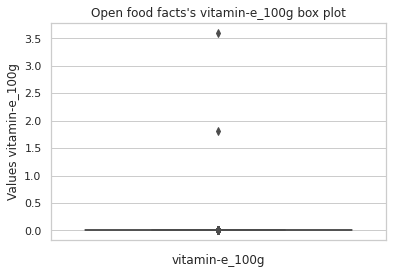

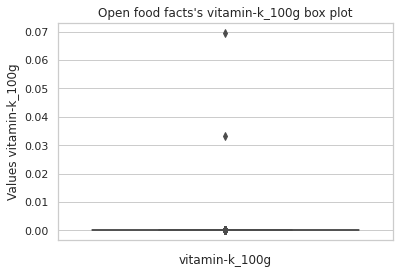

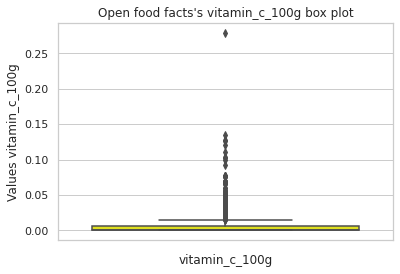

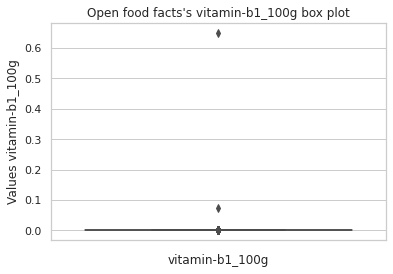

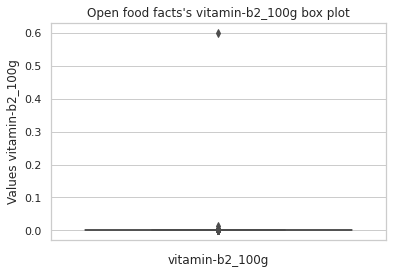

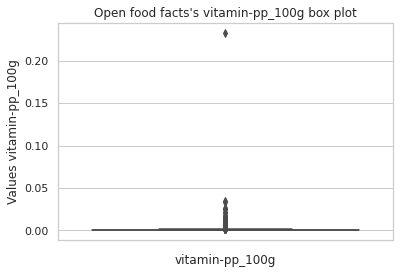

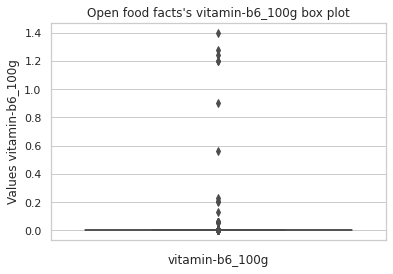

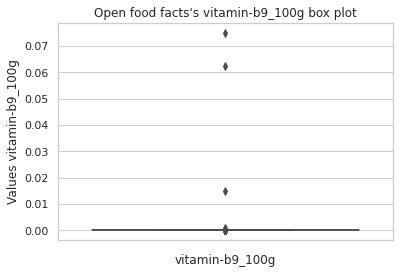

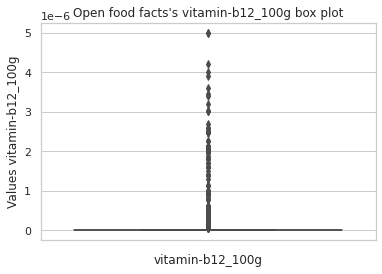

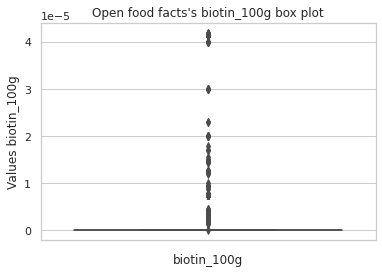

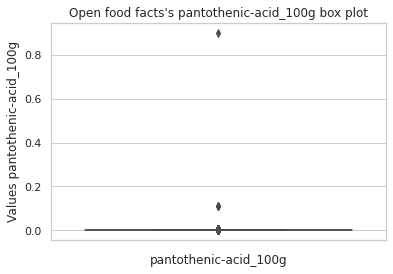

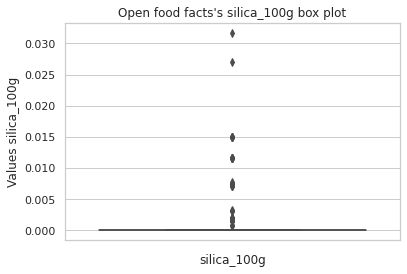

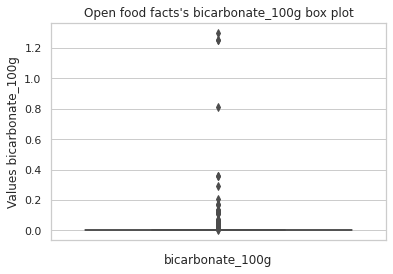

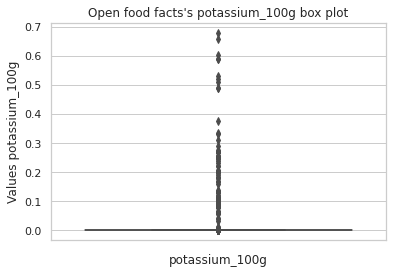

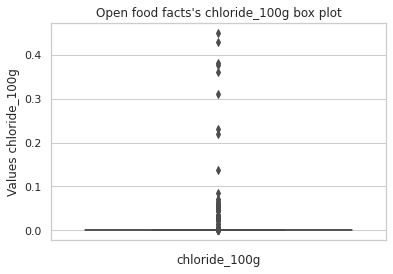

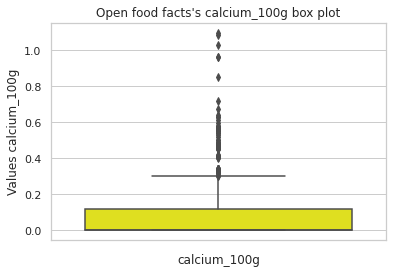

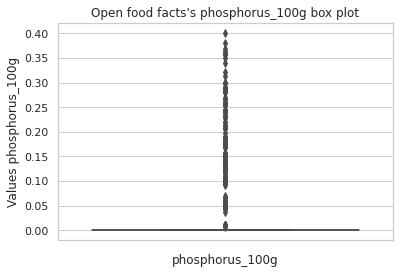

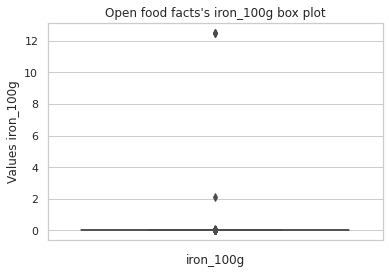

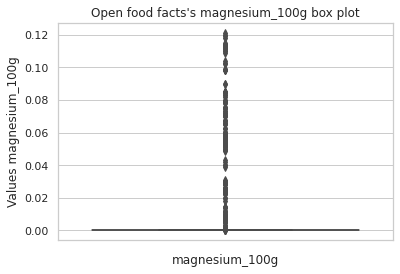

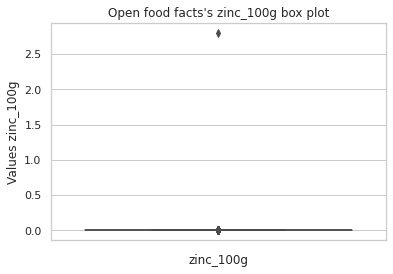

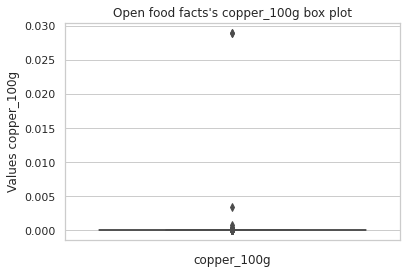

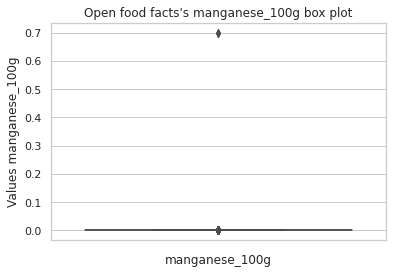

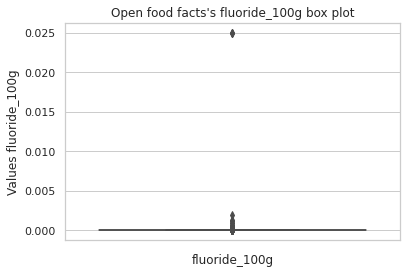

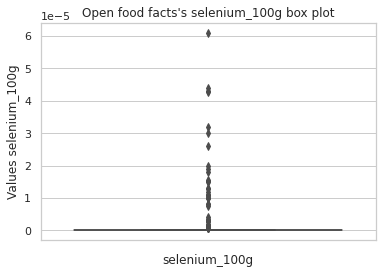

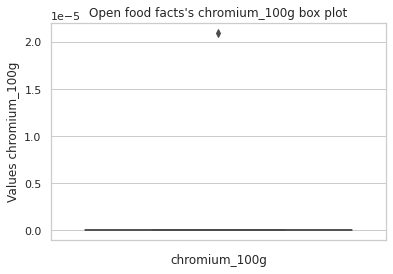

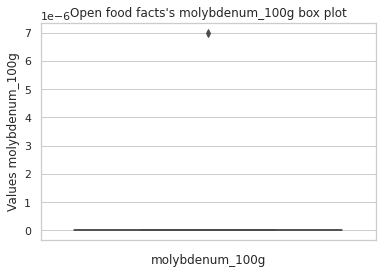

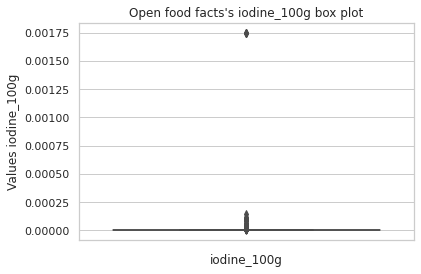

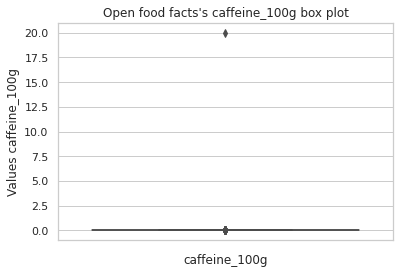

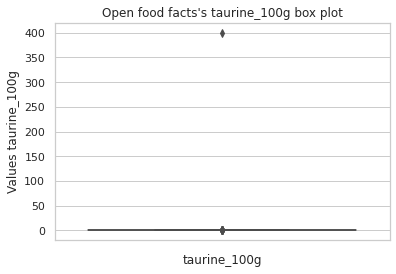

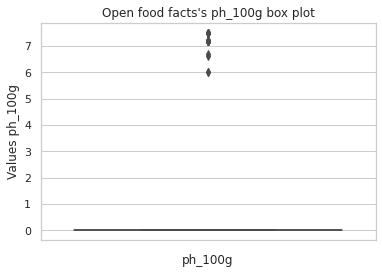

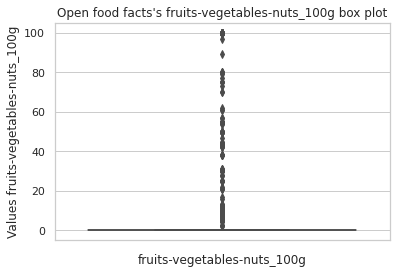

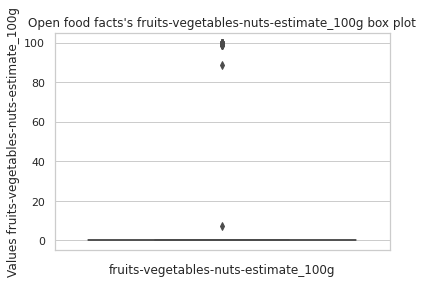

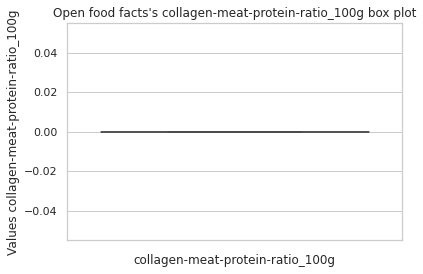

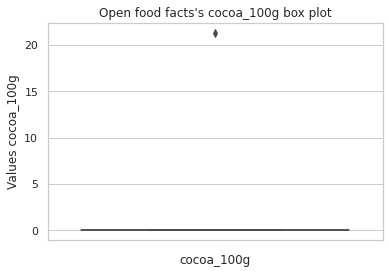

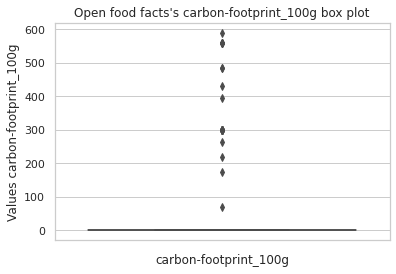

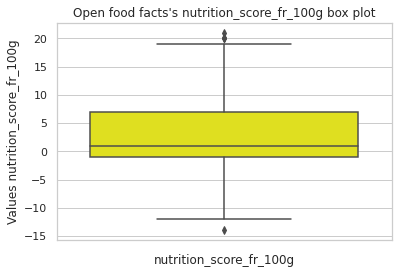

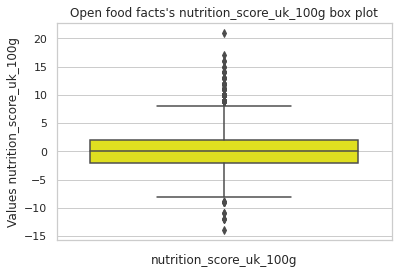

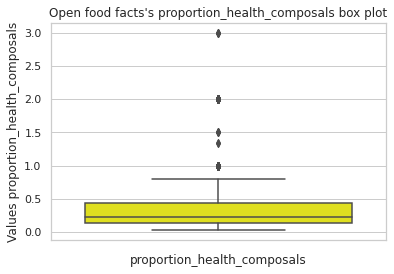

In [23]:
#Check outlayers decline in real variables box plots.
plot_box_plots_real_variables(df_real)

<h3>5. Bivariate analysis.</h3>
<h4>5.1 Correlation between real variables.</h4>
<p>Checking the strength of relationship between variables that are continous.</p>

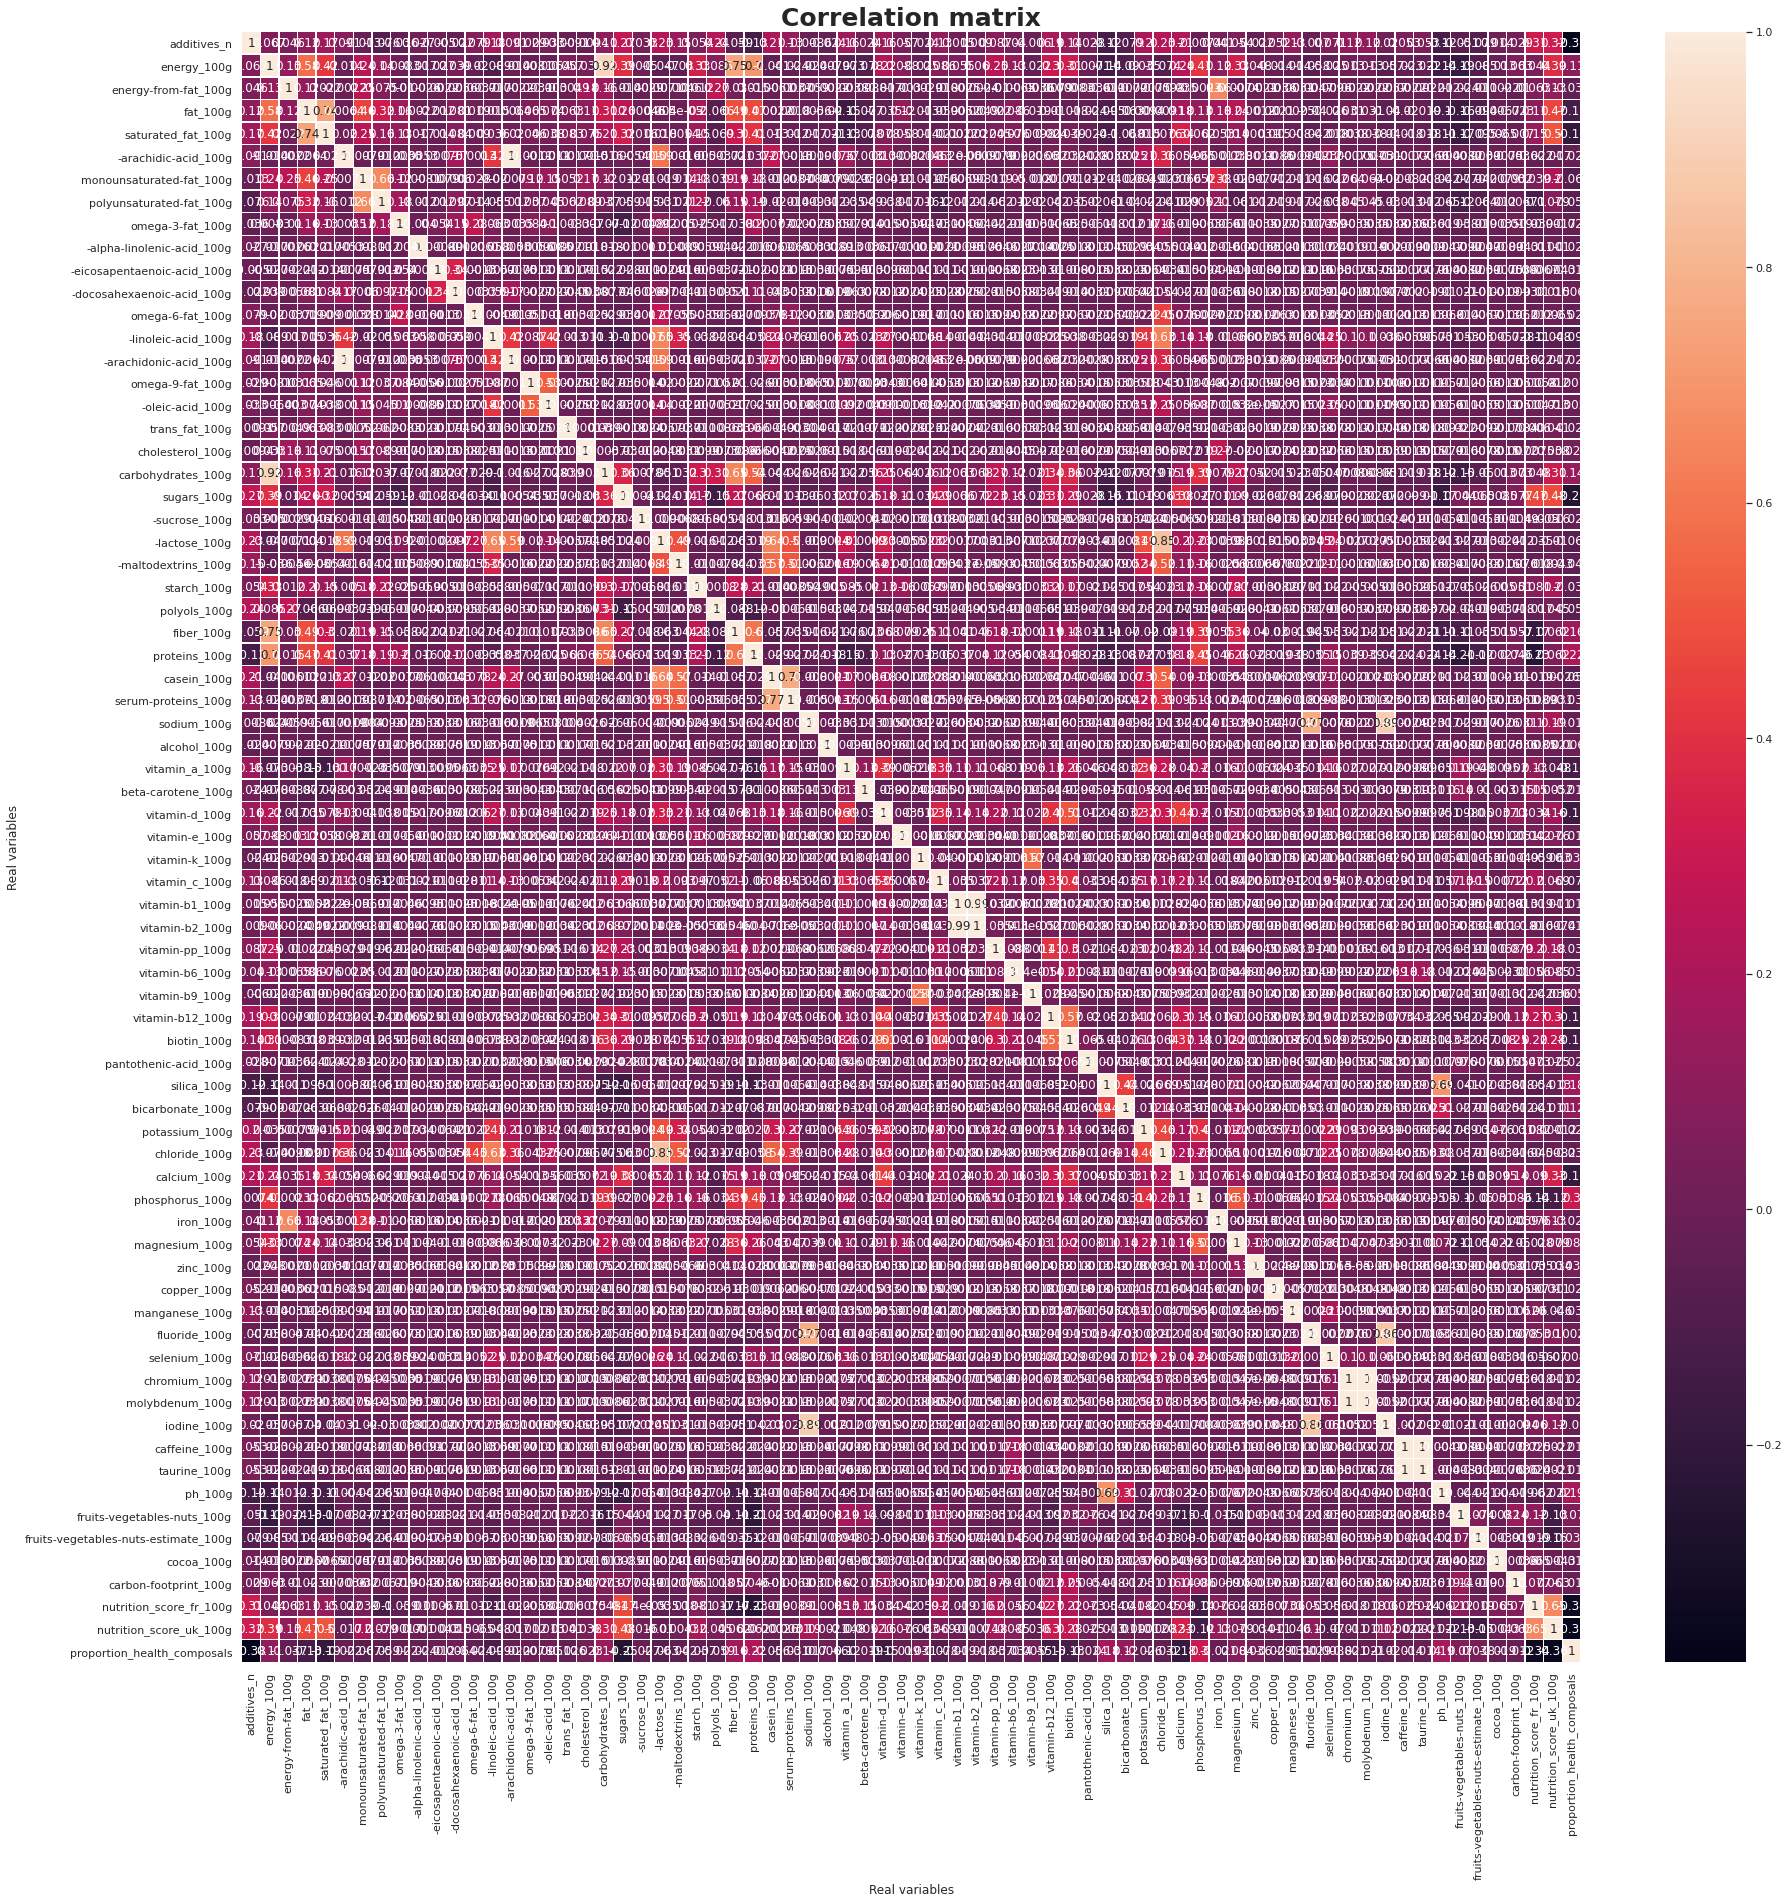

                                                            0
v1                      v2                                   
nutrition_score_fr_100g nutrition_score_fr_100g      1.000000
                        nutrition_score_uk_100g      0.777311
                        sugars_100g                  0.687535
                        proportion_health_composals  0.676726
                        additives_n                  0.556915
                        vitamin-b12_100g             0.460387
                        biotin_100g                  0.410372
                        vitamin-pp_100g              0.388382
                        vitamin_c_100g               0.359277
                        phosphorus_100g              0.334689
                        calcium_100g                 0.308200
                        proteins_100g                0.269946
                        saturated_fat_100g           0.260719
                        beta-carotene_100g           0.239213
        

In [24]:
#Creation of the correlation matrix.
corrMatrix = df_real.corr().fillna(0)

#Removing all zero rows and columns.
corrMatrix = corrMatrix.loc[(corrMatrix != 0).any(axis=1)]
corrMatrix = corrMatrix.loc[:, (corrMatrix != 0).any(axis=0)]
#print(corrMatrix)

fig, ax = plt.subplots(figsize=(30,30))
sns.heatmap(corrMatrix, annot=True, linewidths=.5, ax=ax)
plt.title("Correlation matrix",fontsize=25, fontweight='bold')
plt.xlabel('Real variables',)
plt.ylabel('Real variables')
#plt.figure(figsize=(10,10))
plt.show()

#list heavy relations.
c = corrMatrix.corr().abs()
s = c.unstack()
so = s.sort_values(kind="quicksort", ascending=False)
so = so.to_frame()
so.index.set_names(['v1', 'v2'], inplace=True)
so_scores = so.iloc[so.index.get_level_values('v1') == "nutrition_score_fr_100g"]
#so = so.iloc[so.index.get_level_values('nutrion_score_fr_100g') == 1]
print(so_scores.head(15))
print("")
print(so.head(200))

<h4>5.2 ANOVA Analysis (categorical features vs target variable).</h4>
<p>ANOVA assumptions are checked :</p>
<p> - Independence of data : labeled data picking-up product by product.</p>
<p> - The dependent variable should be normally distributed. For non-normality distribution in data, the test may be valid when having a large sample.</p>
<p> - Homoscedasticity or Homogeneity of variances (variances are equal between treatment groups) (Levene’s or Bartlett’s Test).</p>
<p>Understand the strength of relationship between the categorical variables in the dataset and the nutrition score.</p>
<p>Means of real variables should change in regards categories on categorical variables, to be considered good relevant explanators.</p>
<p>The variable of interest is "nutrition_score_fr_100g", the categorical explanator is "main_category_en.</p>

<h3>Evaluating normality.</h3>
<p>ANOVA assumptions are checked :</p>

In [25]:
#Remerging the dataframe after real and cateogrical analysis.
data = concatenate_df_parts(df_categorical, df_real)

#Obtaining dictionary with variance per categories.
dict_prod_scores_per_categories = obtain_dfs_vals_for_categories_in_column(data,'main_category_en','nutrition_score_fr_100g')
print(data.shape)

(1335, 91)


In [26]:
print(data['main_category_en'].unique())

['Baby foods' 'Plant-based foods and beverages' 'Food additives'
 'Fruit juices' 'Fresh foods' 'Sugary snacks' 'Beverages' 'Desserts'
 'fr:Poudre-petit-dejeuner' 'Frozen foods' 'Groceries' 'Dairies'
 'Breakfasts' 'fr:Teurgoules' 'Fruit juices and nectars' 'Seafood'
 'Tabbouleh' 'fr:Boisson-a-base-d-avoine'
 'fr:Boisson-biologique-a-base-de-riz-aromatisee-a-l-amande' 'Spreads'
 'Meals' 'fr:Pates' 'Olives' 'Green olives' 'Whole olives' 'Canned foods'
 'fr:Eau-d-erable' 'Labeled products' 'fr:Yaourt-maigre'
 'fr:Desserts-au-caramel' 'Meats' 'Sweeteners' 'fr:Aliments-dietetiques'
 'Dietary supplements' 'fr:Riz-basmati-demicomplet' 'Salty snacks'
 'fr:Poelee-de-legumes' 'Chips and fries' 'fr:Tapioca'
 'fr:Biscuits-petit-dejeuner' 'Farming products' 'Fats' 'Coconut-waters'
 'Juice-drinks' 'Sandwiches' 'fr:Galettes-vegetales' 'fr:Repas-minceur'
 'fr:Galette-de-tofu' 'fr:Galettes-de-tofou' 'fr:Vins-chinois'
 'fr:Subtituts-de-repas' 'fr:Chewing-gum-sans-sucres-gout-fraise'
 'fr:Biscoito' 'Pizza

Text(0.5, 1.0, "Box plots' nutrition score and products categories")

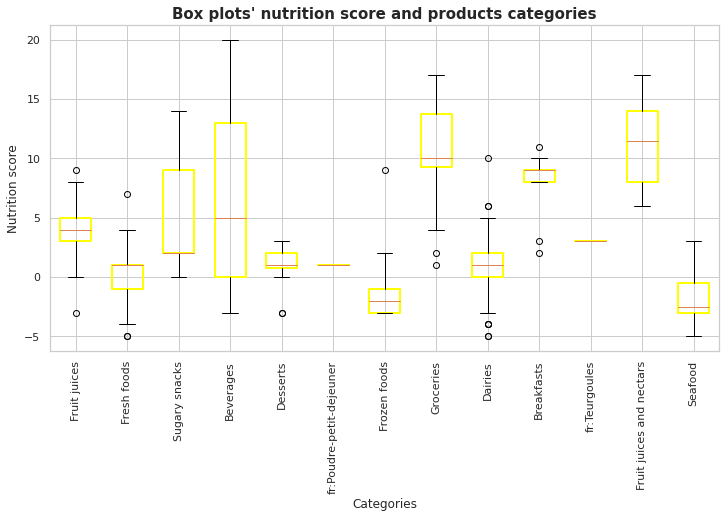

In [27]:
#Printing box plots of nutrition scores per categories.
plt.figure(0,figsize=(12,6))
box_plots_real_variable_categories_feature(dict_prod_scores_per_categories, 3,13)
plt.title("Box plots' nutrition score and products categories",fontsize=15,fontweight="bold")

<h3>Shapiro test to evaluate normality.</h3>
<p>ANOVA assumptions of normality is checked</p>

ShapiroResult(statistic=0.9502508044242859, pvalue=7.529128798015503e-21)

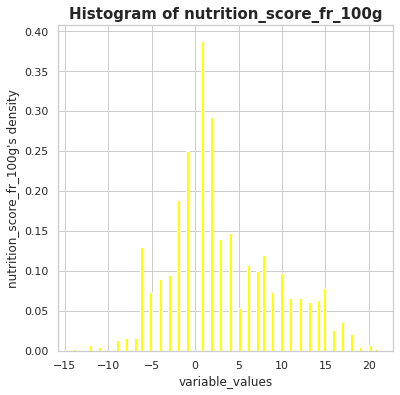

In [28]:
#Histogram for nutrition_score_fr_100g.
plt.figure(0,figsize=(6,6))
plot_column_histogram(df_real, 'nutrition_score_fr_100g', 0)
plt.xlabel('variable_values')
plt.title("Histogram of "+'nutrition_score_fr_100g',fontsize=15,fontweight="bold")
plt.ylabel("nutrition_score_fr_100g's density")
    
#The test is an F(one tail).
#Null hyptohesis :the variable is normally distributed.
#Since p-value is 1.06e-16 then the NH is rejeted. (The varialbe doesn't folllow a normal distribution)
shapiro(df_real['nutrition_score_fr_100g'])

<h3>Evaluating Homoscedasticity.</h3>
<p>ANOVA assumption of equal variance of categories is checked:</p>

In [29]:
#The test is an 
#Null hypothesis: All the k-sample populations have equal variances.
#Since p-value is 1.78e-166 then the NH is rejeted. (The groups within the variable don't have equally variance).
from scipy.stats import levene
print(levene(*dict_prod_scores_per_categories.values()))
print("")
print([np.var(x) for x in list(dict_prod_scores_per_categories.values())])

LeveneResult(statistic=14.881335687945146, pvalue=2.8769505047124275e-104)

[7.925555555555556, 41.10978624400175, 0.0, 3.757633136094674, 3.3206459054209927, 18.563305785123966, 47.400236686390535, 2.16, 0.0, 7.754132231404961, 16.685950413223143, 4.454774502393549, 6.071005917159763, 0.0, 9.045351473922901, 6.555555555555556, 0.0, 0.0, 0.0, 25.0, 10.952380952380953, 0.0, 0.888888888888889, 0.0, 0.0, 9.5, 0.0, 0.25, 0.0, 0.0, 0.6875, 0.0, 0.0, 0.0, 0.0, 2.1599999999999997, 0.0, 0.0, 0.0, 0.0, 0.1875, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


<h3>Evaluating ANOVA over main categories of products.</h3>
<p> The results may be not reliable because two of the assumptions where violated:</p>

In [30]:
#Following the ANOVA.
#The null hypothesis is that there is bo difference in the means between the groups.
#The H0 hypothesis is rejeted when the p-value is bigger than 0.05.(based on the signiicance)
#It means, that if the Pr is too small, the F estimator falls extremely on the right.
#The nutriscore differs upon the categories in the "main_category_en" variable. 
model = ols('nutrition_score_fr_100g ~ C(main_category_en)', data=data).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

sum_sq      df          F        PR(>F)
C(main_category_en)  14691.616685    57.0  10.126416  2.165623e-69
Residual             32503.481442  1277.0        NaN           NaN

<h3>6. Multivariate analysis.</h3>
<h4>6.1 Principal Component Analysis</h4>
<p>Applying principal component analysis to check the explained variance of real features within the dataframe.</p>
<p> - Eagering to understand real features that explain the largest amount of variance in the dataframe.</p>
<p> - The feature's explained variance is represented by two vectors (coordinates), for which each feature has a pair.</p>
<p> - Within this analysis the nutrition score columns are omitted.</p>
<p> - The contributions of each feature are visually depicted by a heap map.</p>

In [31]:
#Applying PCA's to check variable explained variance within the dataframe.
#Filling nan values with 0.
x_real = df_real.drop(['nutrition_score_fr_100g', 'nutrition_score_uk_100g'], axis=1)
#Normalizing each real column of the database.
x_real_normalized = StandardScaler().fit(x_real).transform(x_real) 

#Applying the PCA to the dataframe.
pca = PCA(n_components = 2).fit(x_real_normalized)
df_pca = pca.transform(x_real_normalized)

[5.73335756 4.97990801]
(2, 76)
[[ 0.14175945  0.25603798  0.02923244  0.16812012  0.15807986  0.14607541
   0.07643062  0.03716633  0.03355716  0.00801865 -0.00831416  0.03167848
   0.0478257   0.17912814  0.14607541  0.          0.01819989  0.06872985
   0.00394551  0.00752167  0.2269511   0.15840321  0.00488219  0.
   0.          0.25003365  0.          0.15514336  0.13097124 -0.01120142
   0.1985627   0.18997397  0.17530573  0.13641662  0.         -0.01857175
  -0.01125811  0.1383715  -0.02399134  0.24451578  0.03200206 -0.00868668
   0.15776456  0.03462098  0.03477918  0.12957173  0.06594307  0.00034892
   0.19478202  0.20680655  0.00464299 -0.0640239  -0.03662208  0.21072184
   0.22246729  0.21093894  0.22276694  0.03217879  0.16829852  0.01448078
   0.00657836  0.02034196 -0.02523054  0.10037083  0.04056443  0.04056443
  -0.00709908 -0.00492954 -0.00483855 -0.06767955 -0.07082277 -0.03608013
   0.          0.00275226  0.04657141 -0.04823352]
 [ 0.06684295 -0.30441561 -0.05769557

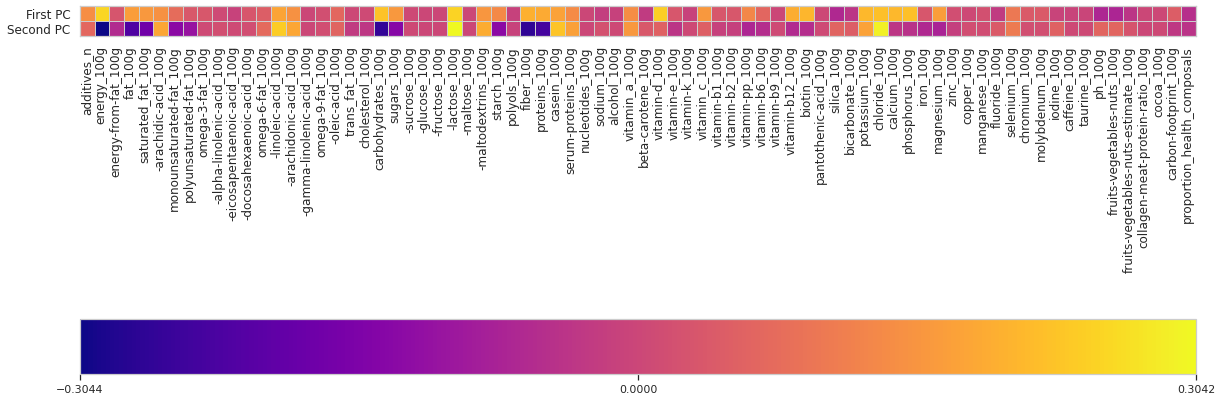

In [32]:
#PCA heat map to characterized fastly the relevant variables in the dataframe. 
fig = plt.figure(figsize=(20, 8))
#pca,components is giving us the components values for each original feature.
print(pca.explained_variance_)
print(pca.components_.shape)
print(pca.components_)
print(pca.explained_variance_ratio_)
plt.imshow(pca.components_, interpolation = 'none', cmap = 'plasma')
feature_names = list(x_real.columns)

plt.gca().set_xticks(np.arange(-.5, len(feature_names)-1));
plt.gca().set_yticks(np.arange(0.5, 2));
plt.gca().set_xticklabels(feature_names, rotation=90, ha='left', fontsize=12);
plt.gca().set_yticklabels(['First PC', 'Second PC'], va='bottom', fontsize=12);

plt.colorbar(orientation='horizontal', ticks=[pca.components_.min(), 0, 
                                              pca.components_.max()], pad=0.65);

<h4>6.2 Feature importance with LASSO regression</h4>
<p>Addressing the selection of features by using a Linear regression with L1 regularization over feauture coefficients<p>

(76, 2)
(20, 2)
                                                              Feature_name  \
Feature_name                                                                 
additives_n                                                    additives_n   
sugars_100g                                                    sugars_100g   
sodium_100g                                                    sodium_100g   
fat_100g                                                          fat_100g   
starch_100g                                                    starch_100g   
fruits-vegetables-nuts_100g                    fruits-vegetables-nuts_100g   
taurine_100g                                                  taurine_100g   
fruits-vegetables-nuts-estimate_100g  fruits-vegetables-nuts-estimate_100g   
carbon-footprint_100g                                carbon-footprint_100g   
energy-from-fat_100g                                  energy-from-fat_100g   
energy_100g                                     

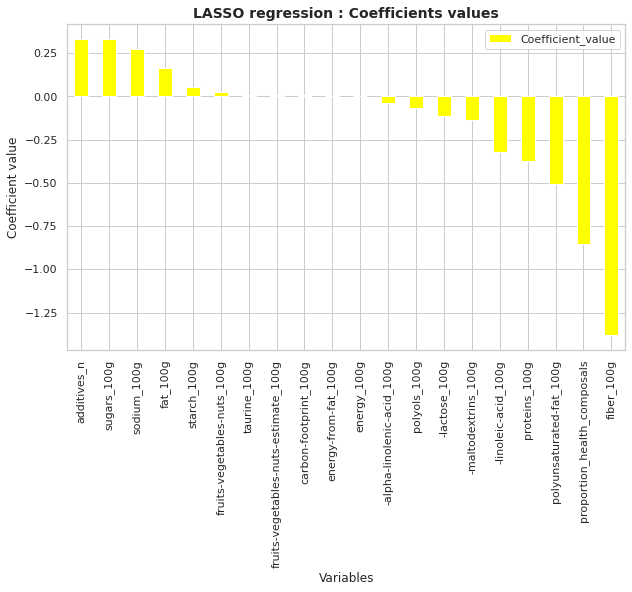

In [33]:
#Scaling the data.
X = df_real.drop(['nutrition_score_fr_100g', 'nutrition_score_uk_100g'], axis=1)
y = df_real['nutrition_score_fr_100g']

#Dividing the data into train and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

#Scaling the data.
scaler = MinMaxScaler().fit(X_train)
X_train_stand = scaler.transform(X_train)
X_test_stand = scaler.transform(X_test)

#Selecting features using LASSO regression.
selector = SelectFromModel(estimator=linear_model.Lasso(alpha=0.1)).fit(X_train, y_train)
selected_feat = X_train.columns[(selector.get_support())]
#print('total features: {}'.format((X_train.shape[1])))
#print('selected features: {}'.format(len(selected_feat)))
#print('features with coefficients shrank to zero: {}'.format(np.sum(selector.estimator_.coef_ == 0)))
#print(selected_feat)
#print(selector.estimator_.coef_)

sel_features = 1*selector.get_support()

list_vars = X_train.columns
list_coeff = list(selector.estimator_.coef_)

df_selected_lasso = pd.DataFrame(list(zip(list_vars, list_coeff)),columns =['Feature_name', 'Coefficient_value'])
print(df_selected_lasso.shape)
df_selected_lasso = df_selected_lasso[df_selected_lasso['Coefficient_value'] != 0].sort_values(by='Coefficient_value', ascending=False)
df_selected_lasso = df_selected_lasso.reset_index(drop=True)
df_selected_lasso.index = df_selected_lasso['Feature_name']
ax = df_selected_lasso.plot.bar(rot=0, color ="yellow", figsize=(10, 6))
plt.xticks(rotation=90)
plt.title("LASSO regression : Coefficients values",fontsize=14, fontweight='bold')
plt.xlabel('Variables',)
plt.ylabel('Coefficient value')
print(df_selected_lasso.shape)
print(df_selected_lasso)

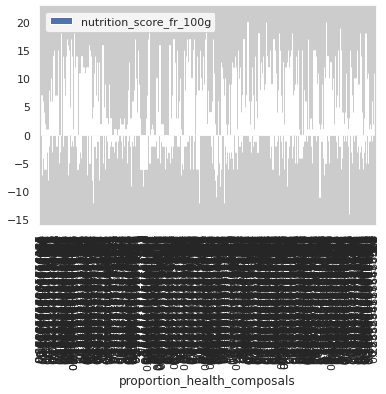

In [41]:
#bar plot for proportion of healthy composals.
var_ = data[['proportion_health_composals','nutrition_score_fr_100g']]
ax = var_.plot.bar(x='proportion_health_composals', y='nutrition_score_fr_100g')